**Find Trends in the data for modeling forward pass**

Similar to `experiments/step_time_analysis.ipynb` we are using current batch data we gathered in profiling to estimate forward pass times with a model

In [8]:
from utils import parse_csv, format_data, concatenate_dataframes # found in utils.py

path1 = 'profiling/train'

# # parse and concat all dataframes
df = concatenate_dataframes(path1)
df = format_data(df)
df.head()

,num_total_scheduled_tokens,loop_time,loop_step_time,loop_queue_time,execute_time,scheduler_time,update_time,arrival_rate,time_stamp,sum_cached_prefill_tokens,max_cached_prefill_tokens,num_prefills,sum_decode_tokens,sum_uncached_prefill_tokens,max_uncached_prefill_tokens,sum_prefill_tokens,max_prefill_tokens,num_total_requests
0,9,0.014090,0.006655,0.007436,0.006004,0.000540,0.000088,4,-0.007257,720,720,1,0,9,9,729,729,1
1,0,0.001958,0.000410,0.001548,0.000118,0.000283,0.000005,4,0.006833,0,0,0,0,0,0,0,0,0
2,9,0.113500,0.006068,0.107433,0.005588,0.000428,0.000029,4,0.008790,0,0,1,0,9,9,9,9,1
3,1,0.006715,0.005804,0.000911,0.005472,0.000278,0.000031,4,0.122291,0,0,0,1,0,0,0,0,1
4,1,0.006667,0.005775,0.000893,0.005470,0.000254,0.000031,4,0.129006,0,0,0,1,0,0,0,0,1


In [2]:
def manual_predict(sum_decode_tokens, sum_prefill_tokens, max_prefill_tokens, num_prefills):
    # Your coefficients (in order of the features)
    coef = [3.41298094e-05, 4.15316658e-06, 2.86339254e-06, 
            1.65335979e-03, 5.11182987e-08, -9.48056285e-08, 1.86501432e-07, 
            2.24889167e-05, -7.77693854e-09, 3.21956881e-08, 6.28999508e-06, 
            -1.72890630e-08, -9.60619427e-06, -6.28061729e-04]

    intercept = 0.00568775493503766
    
    # Calculate each polynomial feature
    features = [
        sum_decode_tokens,
        sum_prefill_tokens, 
        max_prefill_tokens,
        num_prefills,
        sum_decode_tokens**2,
        sum_decode_tokens * sum_prefill_tokens,  
        sum_decode_tokens * max_prefill_tokens,
        sum_decode_tokens * num_prefills,
        sum_prefill_tokens**2,
        sum_prefill_tokens * max_prefill_tokens,  
        sum_prefill_tokens * num_prefills,
        max_prefill_tokens**2,
        max_prefill_tokens * num_prefills,
        num_prefills**2
    ]
    
    # Dot product of coefficients and features, plus intercept
    prediction = intercept + sum(c * f for c, f in zip(coef, features))
    return prediction

In [9]:
# train a polynomial regression model to predict execute_time based on num_prefills, sum_decode_tokens, sum_prefill_tokens, and arrival_rate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = df[['sum_decode_tokens', 'sum_uncached_prefill_tokens', 'max_uncached_prefill_tokens','num_prefills']]
y = df['execute_time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
degree = 2 # You can change the degree of the polynomial

poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(X_train, y_train)
print("Polynomial Model Score:", poly_model.score(X_test, y_test))

coefficients = poly_model.named_steps['linearregression'].coef_
intercept = poly_model.named_steps['linearregression'].intercept_
print("Polynomial Coefficients:", str(coefficients))
print("Polynomial Intercept:", intercept)

Polynomial Model Score: 0.9849095440138633
Polynomial Coefficients: [ 0.00000000e+00  3.38283913e-05  9.82346868e-06 -3.11237143e-06
  1.50291993e-03  4.24173346e-08 -1.06897441e-07  1.92844617e-07
  2.60430816e-05 -7.72212201e-09  2.67059068e-08  7.20303280e-06
 -1.06904337e-08 -1.05254706e-05 -9.19828725e-04]
Polynomial Intercept: 0.005708624032334771


In [60]:
# get feature names
feature_names = poly_model.named_steps['polynomialfeatures'].get_feature_names_out(input_features=X.columns)
print("Feature Names:", feature_names)

Feature Names: ['1' 'sum_decode_tokens' 'sum_uncached_prefill_tokens'
 'max_uncached_prefill_tokens' 'num_prefills' 'sum_decode_tokens^2'
 'sum_decode_tokens sum_uncached_prefill_tokens'
 'sum_decode_tokens max_uncached_prefill_tokens'
 'sum_decode_tokens num_prefills' 'sum_uncached_prefill_tokens^2'
 'sum_uncached_prefill_tokens max_uncached_prefill_tokens'
 'sum_uncached_prefill_tokens num_prefills'
 'max_uncached_prefill_tokens^2'
 'max_uncached_prefill_tokens num_prefills' 'num_prefills^2']


In [10]:
path1 = 'profiling/test/execution_stats_400_32_0.0_Qwen-Qwen2.5-0.5B_sharegpt.csv'

# # parse and concat all dataframes
df = parse_csv(path1)
df = format_data(df)
df.head()

X_test = df[['sum_decode_tokens', 'sum_uncached_prefill_tokens', 'max_uncached_prefill_tokens','num_prefills']]
y_test = df['execute_time']

# score
score = poly_model.score(X_test, y_test)
print("Test Score:", score)

Test Score: 0.9714634522901741


In [21]:
poly_features = poly_model.named_steps['polynomialfeatures']
print(poly_features.fit_transform(X_test)[0])
print("Polynomial Features:", poly_features.get_feature_names_out(X.columns))

[  1.  10.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]
Polynomial Features: ['1' 'sum_decode_tokens' 'sum_prefill_tokens' 'max_prefill_tokens'
 'num_prefills' 'sum_decode_tokens^2'
 'sum_decode_tokens sum_prefill_tokens'
 'sum_decode_tokens max_prefill_tokens' 'sum_decode_tokens num_prefills'
 'sum_prefill_tokens^2' 'sum_prefill_tokens max_prefill_tokens'
 'sum_prefill_tokens num_prefills' 'max_prefill_tokens^2'
 'max_prefill_tokens num_prefills' 'num_prefills^2']


In [ ]:
[1.000e+00 4.300e+01 0.000e+00 0.000e+00 0.000e+00 1.849e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
['1' 'sum_decode_tokens' 'sum_prefill_tokens' 'max_prefill_tokens' 'num_prefills' 'sum_decode_tokens^2' 'sum_decode_tokens sum_prefill_tokens' 'sum_decode_tokens max_prefill_tokens' 'sum_decode_tokens num_prefills' 'sum_prefill_tokens^2' 'sum_prefill_tokens max_prefill_tokens' 'sum_prefill_tokens num_prefills' 'max_prefill_tokens^2' 'max_prefill_tokens num_prefills' 'num_prefills^2']

In [ ]:
df['1'] = [1] * len(df)
df['sum_decode_tokens^2'] = df['sum_decode_tokens'] ** 2
df['sum_prefill_tokens^2'] = df['sum_prefill_tokens'] ** 2
df['num_prefills^2'] = df['num_prefills'] ** 2
df['max_prefill_tokens^2'] = df['max_prefill_tokens'] ** 2
df['sum_decode_tokens sum_prefill_tokens'] = df['sum_decode_tokens'] + df['sum_prefill_tokens']
df['sum_decode_tokens max_prefill_tokens'] = df['sum_decode_tokens'] + df['max_prefill_tokens']


In [ ]:
import time

start_time = time.time()
model_predictions = model.predict(X_test)
end_time = time.time()
print("Linear Model Predictions:", model_predictions[:5])
print("Time taken for predictions:", end_time - start_time)

start_time = time.time()
poly_model_predictions = poly_model.predict(X_test)
end_time = time.time()
print("Linear Model Predictions:", poly_model_predictions[:5])
print("Time taken for predictions:", end_time - start_time)


Linear Model Predictions: [0.00762184 0.00755918 0.00530342 0.02803918 0.00818578]
Time taken for predictions: 0.0032470226287841797
Linear Model Predictions: [0.00743362 0.00739111 0.00590736 0.0267459  0.00781929]
Time taken for predictions: 0.007442951202392578
Tree Model Predictions: [0.00726286 0.0072432  0.00595933 0.02703056 0.00748714]
Time taken for predictions: 0.0372920036315918


In [10]:
# generate a set of n arrival times a r req/sec with a poisson distribution
import numpy as np


def generate_arrival_times(num_reqs, arrival_rate, burstiness = 1.0, seed=None):
    if seed is not None:
        np.random.seed(seed)

    
    theta = 1 / (arrival_rate * burstiness)
    inter_arrival_times = np.random.gamma(shape=burstiness, scale=theta, size=num_reqs)

    inter_arrival_times = np.array([0] + list(inter_arrival_times))  # Ensure the first arrival time is 0
    
    
    return inter_arrival_times

print(generate_arrival_times(4999, 100, burstiness=1.0, seed=42))

[0.         0.00469268 0.03010121 ... 0.0012713  0.00397263 0.01691437]


In [5]:
completion_times = [3263318.385350314,
3263320.093323135,
3263325.339924318,
3263321.830058784,
3263321.764740103,
3263322.355931656,
3263319.467274607,
3263320.270849719,
3263320.887371084,
3263318.752559994,
3263319.052819641,
3263320.903500597,
3263318.95152081,
3263320.833412989,
3263320.329039759,
3263319.043562272,
3263319.052903208,
3263321.731713587,
3263319.09453226,
3263319.119173516,
3263322.143112886,
3263319.167556164,
3263319.17561714,
3263319.184618783,
3263322.6377181,
3263319.646150039,
3263319.297292212,
3263320.46482039,
3263322.403188328,
3263319.607273997,
3263320.83319657,
3263319.43462478,
3263323.130916668,
3263319.434700328,
3263321.800033015,
3263319.779249992,
3263319.744440769,
3263321.069496428,
3263320.190373743,
3263322.508129195,
3263319.835580915,
3263327.132541752,
3263319.879169263,
3263320.671278021,
3263322.007283452,
3263325.209543696,
3263320.026128416,
3263324.436798935,
3263320.070044041,
3263320.383691841,
3263323.510775452,
3263327.496597428,
3263320.313070091,
3263320.433065337,
3263320.871056875,
3263321.014855317,
3263322.088231108,
3263324.755051628,
3263321.3549682,
3263321.618607442,
3263320.690902014,
3263320.708446242,
3263325.075100457,
3263326.104805039,
3263320.815053538,
3263320.833087686,
3263324.746086483,
3263320.863150887,
3263324.785847912,
3263322.157298179,
3263321.103461696,
3263323.183526966,
3263323.439203942,
3263322.458569616,
3263321.243261025,
3263323.106132615,
3263324.915219133,
3263321.411023728,
3263321.41120127,
3263328.297210871,
3263324.987918033,
3263327.682189455,
3263324.079778536,
3263326.54950177,
3263326.223752595,
3263321.599245385,
3263323.43103302,
3263321.655366812,
3263325.935164742,
3263329.064686299,
3263321.810782631,
3263322.118794852,
3263323.006173183,
3263322.118401398,
3263327.461856049,
3263322.174802031,
3263323.290967781,
3263322.088465383,
3263322.118526805,
3263322.118586277,
3263325.659133332,
3263325.157312151,
3263322.157210849,
3263322.174692527,
3263325.266161682,
3263325.031438362,
3263323.955038687,
3263324.218554776,
3263322.449996895,
3263322.962552526,
3263322.561235141,
3263325.815506255,
3263328.539535147,
3263322.534814094,
3263322.599804518,
3263322.637200043,
3263323.122900277,
3263322.783124091,
3263324.097294584,
3263322.989367533,
3263323.175479869,
3263323.585253565,
3263328.229053805,
3263325.240388604,
3263325.005631257,
3263324.461375869,
3263323.743669247,
3263323.202962528,
3263323.27408587,
3263325.075565982,
3263323.803571437,
3263323.92467287,
3263323.343938304,
3263323.369291342,
3263328.261365275,
3263326.978272582,
3263325.588462734,
3263328.186284711,
3263327.823733994,
3263324.946873572,
3263323.735168216,
3263327.263397002,
3263323.88153068,
3263323.912767241,
3263323.924419395,
3263325.444948698,
3263327.100421915,
3263328.388608784,
3263324.00902607,
3263324.008591916,
3263326.796270559,
3263325.075668971,
3263325.405652443,
3263326.405721761,
3263326.657268402,
3263327.67298976,
3263324.581756292,
3263324.391145507,
3263325.453669554,
3263325.498757489,
3263324.522632266,
3263324.659710909,
3263328.996080087,
3263328.890256523,
3263324.659617565,
3263324.659120263,
3263328.625543811,
3263324.955247291,
3263327.524559085,
3263325.192076032,
3263324.785602541,
3263324.833472175,
3263327.935864927,
3263326.152708519,
3263324.877006005,
3263325.405277249,
3263324.929305952,
3263325.04893286,
3263325.057581291,
3263327.285677251,
3263326.473777243,
3263325.12493764,
3263325.13932449,
3263325.231428348,
3263326.512816632,
3263332.449431619,
3263331.279181073,
3263325.445159633,
3263328.11005687,
3263329.64302752,
3263325.886145908,
3263326.178612613,
3263327.487297206,
3263327.06787036,
3263325.815354809,
3263328.700176206,
3263325.94394195,
3263328.667454543,
3263325.987583944,
3263327.304746738,
3263326.079686609,
3263328.97247132,
3263326.115880687,
3263329.410454149,
3263327.461990747,
3263329.509366407,
3263328.414863612,
3263329.533453601,
3263328.773251835,
3263326.318597718,
3263327.075686252,
3263326.92080525,
3263326.423292956,
3263326.444324632,
3263327.690638977,
3263326.501370556,
3263327.682348789,
3263330.521968781,
3263326.858019756,
3263326.640174201,
3263330.497728691,
3263326.96402609,
3263326.781731492,
3263327.567854674,
3263326.809431822,
3263326.947228591,
3263327.619141187,
3263326.978179281,
3263329.921494182,
3263327.091856663,
3263327.313375496,
3263327.409995606,
3263328.608737926,
3263328.496675504,
3263327.285794457,
3263327.305124022,
3263329.77258652,
3263327.936256028,
3263328.531276491,
3263327.45217559,
3263327.4248844,
3263328.906541392,
3263327.978392782,
3263333.405425794,
3263329.106202857,
3263328.314544441,
3263329.217286518,
3263327.901617346,
3263328.033045526,
3263328.168981234,
3263329.557166785,
3263328.415137656,
3263328.289034787,
3263335.424317412,
3263329.764297658,
3263330.964299477,
3263335.500471542,
3263331.961305278,
3263328.874040464,
3263328.608869984,
3263329.959901058,
3263333.175693629,
3263329.881964177,
3263331.65760421,
3263330.931255751,
3263334.817025428,
3263332.73800714,
3263331.186864706,
3263329.098944172,
3263333.15781348,
3263329.683888208,
3263331.751735201,
3263329.271052826,
3263329.650617944,
3263329.445942443,
3263329.483187241,
3263330.356966476,
3263329.576267505,
3263333.309141327,
3263330.052536764,
3263329.731997147,
3263330.004805413,
3263329.836303933,
3263329.960456507,
3263332.431171049,
3263330.356885846,
3263332.968179083,
3263329.921363474,
3263329.949725609,
3263332.147128762,
3263333.433179187,
3263332.003953432,
3263334.676064669,
3263330.077412739,
3263333.45027611,
3263330.44877785,
3263330.126288287,
3263330.947123245,
3263332.298235317,
3263330.240858929,
3263330.241187035,
3263337.470175025,
3263330.284394019,
3263334.77211751,
3263330.348491455,
3263331.340020744,
3263335.934549842,
3263331.560806146,
3263330.685005826,
3263330.806468593,
3263330.677151995,
3263332.119242965,
3263333.631214081,
3263332.492582944,
3263330.836015848,
3263330.905619999,
3263330.964051714,
3263330.988786468,
3263333.340449496,
3263330.989326194,
3263331.01451646,
3263331.312467289,
3263331.084602662,
3263332.227541462,
3263332.011980972,
3263331.402338259,
3263331.323672452,
3263333.3965573,
3263331.394295092,
3263331.686800254,
3263332.34610973,
3263332.049454969,
3263337.277047276,
3263332.100421188,
3263331.526007875,
3263337.56997499,
3263331.526602562,
3263334.440175101,
3263332.772681931,
3263333.648976815,
3263335.136746584,
3263331.709947153,
3263336.490790308,
3263336.162274802,
3263334.929836255,
3263331.784515319,
3263332.109407223,
3263336.915208771,
3263331.860366063,
3263331.887206913,
3263336.307269518,
3263331.952655257,
3263334.955699686,
3263335.391818336,
3263332.937969663,
3263335.543445818,
3263334.262015453,
3263332.755236799,
3263334.44880175,
3263334.295875349,
3263332.309568472,
3263335.861975929,
3263332.375440636,
3263332.685254969,
3263332.85123505,
3263333.130938557,
3263337.38797801,
3263332.703322504,
3263334.791401656,
3263332.817632579,
3263338.933243018,
3263333.200880177,
3263338.187440589,
3263332.833507761,
3263335.655694822,
3263332.864813878,
3263332.930023922,
3263336.58275398,
3263332.968296615,
3263333.787166919,
3263333.901280635,
3263333.064166689,
3263333.274629688,
3263334.638529535,
3263336.697561682,
3263336.276628842,
3263333.37076605,
3263336.931935084,
3263336.448258732,
3263334.595154831,
3263334.891379924,
3263335.004692755,
3263333.855683023,
3263336.697457608,
3263333.768878658,
3263335.870399468,
3263338.085354273,
3263335.960406422,
3263334.064650879,
3263337.765029571,
3263334.120207218,
3263336.69762851,
3263334.217052947,
3263334.827899853,
3263336.29009164,
3263334.540602499,
3263334.418164844,
3263337.486754157,
3263336.126716656,
3263335.357424679,
3263334.540740568,
3263338.293021201,
3263335.307633073,
3263337.918966595,
3263338.320469054,
3263334.869812621,
3263335.718851337,
3263335.120204117,
3263334.929338891,
3263334.977284034,
3263335.9772844,
3263337.02999155,
3263335.149919578,
3263341.049037446,
3263339.440683183,
3263335.482039637,
3263337.388421212,
3263337.072233731,
3263337.631846289,
3263338.134872457,
3263337.623686609,
3263339.533414461,
3263335.423613035,
3263335.452430072,
3263335.664527561,
3263335.745180027,
3263337.1611862,
3263335.552558724,
3263335.817392256,
3263335.753760777,
3263335.656094098,
3263336.232656593,
3263336.056734008,
3263336.020646264,
3263335.86117766,
3263338.366215925,
3263338.812962812,
3263337.721779364,
3263338.260462096,
3263336.290500406,
3263338.243831662,
3263339.065997761,
3263336.39112952,
3263336.783494366,
3263336.504101989,
3263336.651991435,
3263336.545160661,
3263336.545060133,
3263336.570618008,
3263338.05517638,
3263339.861003445,
3263338.320374292,
3263336.625349366,
3263336.740890503,
3263336.714456084,
3263342.122266828,
3263344.137664775,
3263339.034035924,
3263336.959944151,
3263338.582502945,
3263337.118667545,
3263337.118518012,
3263340.146687442,
3263337.251591405,
3263338.08549886,
3263339.125809888,
3263339.517384869,
3263339.887898919,
3263337.606337515,
3263337.739458913,
3263338.203072499,
3263343.376179158,
3263338.624632003,
3263337.885093193,
3263340.67978856,
3263338.235696574,
3263338.055671425,
3263339.501339544,
3263338.102051685,
3263338.18732314,
3263338.485620921,
3263338.965976668,
3263339.596753073,
3263341.017766838,
3263342.695112358,
3263341.066643728,
3263340.591269107,
3263338.444256643,
3263339.009255658,
3263340.008982525,
3263341.211489414,
3263344.275043842,
3263343.245645495,
3263339.264899353,
3263339.347634302,
3263340.891506921,
3263338.99250545,
3263339.077546364,
3263341.259382979,
3263341.289939611,
3263342.669120632,
3263341.890531663,
3263339.384510787,
3263339.493204004,
3263342.970427095,
3263339.579866311,
3263339.579936961,
3263342.105610994,
3263350.972306831,
3263339.839834467,
3263339.85293751,
3263339.888223523,
3263340.915261211,
3263340.057109576,
3263342.677605169,
3263345.297703985,
3263342.685927051,
3263341.442888714,
3263340.263379304,
3263341.05889878,
3263340.991037245,
3263340.615380099,
3263340.875223833,
3263340.967055952,
3263356.70289615,
3263344.372539668,
3263343.543360535,
3263341.259493344,
3263341.270321648,
3263341.289713792,
3263344.328876715,
3263344.765966224,
3263342.608832447,
3263341.475464884,
3263341.511336227,
3263341.555100304,
3263344.024747685,
3263347.570196647,
3263346.316794465,
3263341.6531605,
3263344.266044474,
3263341.737922844,
3263341.814946195,
3263343.544221943,
3263343.046766213,
3263342.694880335,
3263342.616865526,
3263343.639987179,
3263345.375759302,
3263349.195134974,
3263342.643228311,
3263345.915174321,
3263345.770066736,
3263342.24608095,
3263343.445952041,
3263348.594341141,
3263347.607727004,
3263345.356594629,
3263345.084367429,
3263342.362184809,
3263343.761219138,
3263344.958544457,
3263343.216769933,
3263342.491933708,
3263350.19661591,
3263346.265875194,
3263342.721225385,
3263348.965437224,
3263343.326874038,
3263344.899037798,
3263342.892580311,
3263342.908059063,
3263343.059559456,
3263343.973367812,
3263343.114267788,
3263343.534740066,
3263343.155011869,
3263343.168506902,
3263345.131296171,
3263343.801097998,
3263345.395461247,
3263345.297190116,
3263343.376654718,
3263346.992702268,
3263349.442109011,
3263347.953021702,
3263345.064383621,
3263344.408294815,
3263345.749299334,
3263343.445641993,
3263344.015034692,
3263345.600566024,
3263345.356811011,
3263343.484376938,
3263343.484077363,
3263347.116685026,
3263351.318397044,
3263344.372368352,
3263345.952864758,
3263345.022365168,
3263345.375636431,
3263343.613822558,
3263343.67854227,
3263346.87873789,
3263343.937687945,
3263343.801404455,
3263344.097823857,
3263345.429920019,
3263343.988966414,
3263344.059462798,
3263346.727226569,
3263344.058753185,
3263348.388644819,
3263344.0810656,
3263344.112303817,
3263344.156893302,
3263345.889012065,
3263347.010936293,
3263344.244201262,
3263346.88812613,
3263348.852341946,
3263346.368557794,
3263346.879219882,
3263344.438022837,
3263345.635522696,
3263344.468165063,
3263344.498548454,
3263348.27447798,
3263344.541861848,
3263344.564276154,
3263344.583790181,
3263345.244163613,
3263349.291070651,
3263344.597967024,
3263344.829530749,
3263345.13904945,
3263344.708087348,
3263344.975588785,
3263344.80264759,
3263346.440911644,
3263344.985450831,
3263349.559171567,
3263344.919177527,
3263348.731216922,
3263345.953160874,
3263348.050461239,
3263348.348350856,
3263345.588693751,
3263345.22619215,
3263345.208513039,
3263345.152716816,
3263349.429671513,
3263345.346990115,
3263347.433980764,
3263351.63678129,
3263345.417592513,
3263349.085429704,
3263347.870451043,
3263345.778154819,
3263350.268456533,
3263345.440924041,
3263346.717753713,
3263346.219208951,
3263345.548873202,
3263345.580661321,
3263345.627129041,
3263345.769938258,
3263345.770469185,
3263347.607284425,
3263350.545062706,
3263349.442252368,
3263347.02888612,
3263346.104978262,
3263346.556528542,
3263346.469935285,
3263349.483417078,
3263346.303306949,
3263346.490983755,
3263346.736910929,
3263350.876754979,
3263346.76542788,
3263346.547991045,
3263347.924141405,
3263346.683633472,
3263350.518046143,
3263350.128042071,
3263346.521434582,
3263346.538980971,
3263347.962483178,
3263349.636466383,
3263350.784052987,
3263354.173040058,
3263346.643567138,
3263346.708890071,
3263349.990762568,
3263346.70869653,
3263349.809338708,
3263347.206640934,
3263346.936627353,
3263347.067860727,
3263355.552472664,
3263349.160531452,
3263348.917925708,
3263349.394508086,
3263347.313007315,
3263347.161107472,
3263347.266975978,
3263351.113750033,
3263347.475492302,
3263347.688216587,
3263350.47345489,
3263347.825004524,
3263347.660370608,
3263350.340695875,
3263347.91492372,
3263350.268052751,
3263347.824669505,
3263350.636632461,
3263355.777003063,
3263348.406555034,
3263347.91427529,
3263347.91499832,
3263348.621825269,
3263348.917742929,
3263350.703853476,
3263348.357174201,
3263348.163386034,
3263348.176550155,
3263348.249862387,
3263348.273913513,
3263349.832081852,
3263348.323479646,
3263348.347636921,
3263350.756597505,
3263348.429743885,
3263352.866384833,
3263350.748824124,
3263348.537275772,
3263350.232271754,
3263348.663573927,
3263348.708474347,
3263351.096311969,
3263352.047093168,
3263348.871085559,
3263356.817664885,
3263348.889499749,
3263350.500238712,
3263349.171626209,
3263349.021459808,
3263357.576650641,
3263351.637029645,
3263349.961272923,
3263355.796323337,
3263349.403750063,
3263349.272633522,
3263352.558381476,
3263349.306075609,
3263349.358017555,
3263350.721805995,
3263352.752066822,
3263350.685908577,
3263349.53207374,
3263349.604996495,
3263351.377802307,
3263354.778705393,
3263352.778524991,
3263349.721025547,
3263349.740192426,
3263349.772698688,
3263351.165538135,
3263349.861585066,
3263354.273905581,
3263351.429128603,
3263350.119785373,
3263349.990894965,
3263352.099780402,
3263351.283864023,
3263350.119612484,
3263350.223665051,
3263350.915873488,
3263350.282418317,
3263350.473885032,
3263353.191798698,
3263356.151288719,
3263353.562214111,
3263353.517780349,
3263351.454836542,
3263355.031002879,
3263350.627765486,
3263354.306763545,
3263350.774426067,
3263350.830703195,
3263353.059237113,
3263352.381849833,
3263351.454469879,
3263352.88585179,
3263350.972738469,
3263351.63722373,
3263351.197524716,
3263351.230209079,
3263351.230682906,
3263351.395044872,
3263351.481492769,
3263351.489669382,
3263351.568401485,
3263351.708052347,
3263351.935286884,
3263351.720405102,
3263354.316770782,
3263351.74760289,
3263352.207779737,
3263351.825082051,
3263356.403538545,
3263351.849111658,
3263355.132144377,
3263354.681330091,
3263355.588821402,
3263352.072178087,
3263355.597556467,
3263354.253567823,
3263353.526705925,
3263352.128184435,
3263352.619223204,
3263355.37865549,
3263352.159799082,
3263355.659413383,
3263352.207915574,
3263352.315797828,
3263352.327310906,
3263352.373120038,
3263352.541017718,
3263352.404877919,
3263352.451745616,
3263352.90429514,
3263353.735128473,
3263352.600413229,
3263355.534369062,
3263356.631303341,
3263352.904219779,
3263358.843648426,
3263352.92370568,
3263354.163365813,
3263354.966575794,
3263352.989722861,
3263356.302137411,
3263353.095082755,
3263354.985453536,
3263360.702243964,
3263353.134608355,
3263354.809150309,
3263354.409873952,
3263353.226305645,
3263354.336551341,
3263359.897127238,
3263353.311625931,
3263355.063168339,
3263356.124305128,
3263359.795499856,
3263353.380741187,
3263354.57671635,
3263355.280580074,
3263355.804784515,
3263354.482166367,
3263353.643532706,
3263353.671777757,
3263353.672434838,
3263354.757667612,
3263353.725922809,
3263357.097162931,
3263354.063892112,
3263353.810934245,
3263357.492797842,
3263353.861562369,
3263353.86097058,
3263353.861464466,
3263353.918468162,
3263356.899820325,
3263359.100505025,
3263353.972437356,
3263354.044544026,
3263354.06440989,
3263354.419262539,
3263354.125550809,
3263354.482280954,
3263357.892305354,
3263356.622805591,
3263356.847126371,
3263356.711580866,
3263355.515224139,
3263356.826901214,
3263355.53448999,
3263357.576755877,
3263357.77358129,
3263355.470391539,
3263354.446367976,
3263354.462943863,
3263355.48074876,
3263362.265530387,
3263354.643395817,
3263354.65923677,
3263357.453471404,
3263357.232567985,
3263354.71613192,
3263357.224095717,
3263354.926910399,
3263355.679789637,
3263354.831354888,
3263355.651201938,
3263355.072614161,
3263355.030908449,
3263355.053122531,
3263355.114314177,
3263355.443059938,
3263355.234303764,
3263358.02503797,
3263362.813259411,
3263355.324164882,
3263355.543462527,
3263355.369823562,
3263355.409773611,
3263359.766171421,
3263356.292593713,
3263355.505537618,
3263357.970790838,
3263355.71027708,
3263356.206576374,
3263356.000257677,
3263357.250604613,
3263357.212582787,
3263355.82830306,
3263361.275179335,
3263355.88431767,
3263357.953024982,
3263355.946535859,
3263360.339264344,
3263356.041261589,
3263356.206682111,
3263356.040770948,
3263357.127253428,
3263363.670990693,
3263356.245786937,
3263356.284114036,
3263356.68460563,
3263356.797024657,
3263356.435359807,
3263357.65530877,
3263357.445284255,
3263359.091117471,
3263356.516707363,
3263358.005881402,
3263357.361215493,
3263361.146844656,
3263359.943260839,
3263361.301673313,
3263356.643442645,
3263360.684525261,
3263360.658112108,
3263356.741121788,
3263356.90909228,
3263359.915397319,
3263357.2913296,
3263356.847267814,
3263357.783270254,
3263357.159454532,
3263358.042265891,
3263357.049801591,
3263357.29977723,
3263360.648068646,
3263361.934437414,
3263357.605270509,
3263364.657550044,
3263357.158632643,
3263360.114517109,
3263358.874968086,
3263359.365214704,
3263357.282093617,
3263357.312933755,
3263357.361812447,
3263358.106296998,
3263357.399810243,
3263362.672387756,
3263357.961952446,
3263360.958099521,
3263362.194099979,
3263359.311336661,
3263357.655225116,
3263357.654734796,
3263357.913820184,
3263360.657961989,
3263362.131048387,
3263358.516026997,
3263360.271836311,
3263357.943660798,
3263358.268452096,
3263358.241611743,
3263359.293771327,
3263359.14737868,
3263359.439752213,
3263358.857210995,
3263358.327096882,
3263359.329051238,
3263359.639256841,
3263358.552984857,
3263359.156180184,
3263358.660968847,
3263358.710268752,
3263366.091875093,
3263360.163227861,
3263359.887738823,
3263365.649542843,
3263360.594442118,
3263359.007090974,
3263359.878269214,
3263361.200607283,
3263359.266989165,
3263362.777746708,
3263361.363373214,
3263359.488100086,
3263364.450238615,
3263359.639369846,
3263362.14767128,
3263366.761106167,
3263359.804495148,
3263359.70243335,
3263362.116649104,
3263359.71591654,
3263359.765664619,
3263361.015714472,
3263359.853056805,
3263360.01459701,
3263362.035150816,
3263362.363190942,
3263368.160338818,
3263360.497721047,
3263359.996711188,
3263363.396515686,
3263360.12478613,
3263364.55897291,
3263365.81479803,
3263361.551737922,
3263363.835444932,
3263361.111975688,
3263363.309837811,
3263360.576434381,
3263360.513109674,
3263360.97644194,
3263360.901114958,
3263360.843070566,
3263363.710679166,
3263363.05119528,
3263361.051334875,
3263361.006511784,
3263366.395162042,
3263363.184152686,
3263363.32866573,
3263365.844460299,
3263364.114723941,
3263361.340506382,
3263363.236512347,
3263365.076172215,
3263362.584423757,
3263361.402618443,
3263364.016350014,
3263362.795526025,
3263361.417982241,
3263361.595529867,
3263361.906937102,
3263361.629986877,
3263362.951703294,
3263363.878954036,
3263361.807888037,
3263361.885436648,
3263361.885234003,
3263364.249664254,
3263368.954530951,
3263362.519458235,
3263362.131396022,
3263362.160424739,
3263362.175326167,
3263363.265787776,
3263365.688545507,
3263362.493463565,
3263365.269277266,
3263365.769436409,
3263362.601895419,
3263362.620934925,
3263366.516286264,
3263363.577156519,
3263368.590345653,
3263364.589966522,
3263362.8310292,
3263363.736749828,
3263366.15511987,
3263362.942587851,
3263366.035280722,
3263364.855851075,
3263365.183940922,
3263363.791613136,
3263366.166753963,
3263363.396890308,
3263364.306569591,
3263369.107635416,
3263363.481328673,
3263363.492790942,
3263367.129550046,
3263366.154961642,
3263363.780265254,
3263363.599643189,
3263367.748399031,
3263369.986608554,
3263365.132922645,
3263365.361583075,
3263363.921629229,
3263363.997868125,
3263364.08171198,
3263366.781069871,
3263367.138275005,
3263365.066684782,
3263370.258381652,
3263365.588426347,
3263364.200622448,
3263364.249549939,
3263369.23076942,
3263366.598585337,
3263366.111891907,
3263367.78361097,
3263364.347893738,
3263367.314095012,
3263366.231387979,
3263366.886263836,
3263366.85738467,
3263364.581892561,
3263364.602697528,
3263364.657387534,
3263365.942629557,
3263367.041312524,
3263366.269355713,
3263368.963706231,
3263365.166316522,
3263364.965870555,
3263365.047465841,
3263367.564251653,
3263365.16581178,
3263367.181291771,
3263365.269525963,
3263368.141751882,
3263365.362037111,
3263365.375923341,
3263369.06360124,
3263365.540803044,
3263366.184151002,
3263367.296632048,
3263371.884577374,
3263367.659985424,
3263365.688216929,
3263365.709208871,
3263365.768860666,
3263366.708650329,
3263365.864616613,
3263368.35175562,
3263367.04121353,
3263366.448359436,
3263368.160246012,
3263367.050320659,
3263366.137446986,
3263366.545423296,
3263366.911973556,
3263371.399558359,
3263368.388395753,
3263366.330181166,
3263366.395736119,
3263366.495493197,
3263369.063318677,
3263371.446373295,
3263366.65567208,
3263369.950399854,
3263367.058390719,
3263367.085400371,
3263366.827729045,
3263368.778478186,
3263369.519456156,
3263366.942004751,
3263369.811912103,
3263369.196725018,
3263368.723493567,
3263372.460936682,
3263367.076468494,
3263367.211101744,
3263368.232655423,
3263367.765752571,
3263369.107801533,
3263369.367647564,
3263367.890943122,
3263371.357482164,
3263368.660938727,
3263367.92684133,
3263367.582389474,
3263370.194858423,
3263371.349175956,
3263370.376564933,
3263368.796297365,
3263371.640209974,
3263367.948812796,
3263368.268113895,
3263368.022730396,
3263369.133707607,
3263371.474259133,
3263373.496963807,
3263368.123462952,
3263368.178089341,
3263368.196096132,
3263371.743075059,
3263368.378802471,
3263368.342385121,
3263371.679467667,
3263368.477588511,
3263369.700077335,
3263372.656597799,
3263374.138958222,
3263368.787893617,
3263373.044340403,
3263375.007678359,
3263369.597461188,
3263370.717530759,
3263372.262767818,
3263368.890453098,
3263372.995598124,
3263373.669314173,
3263372.364543305,
3263369.155917995,
3263369.633336448,
3263369.339436776,
3263371.687301203,
3263369.367227756,
3263369.439591105,
3263377.7253367,
3263374.862246456,
3263374.413272076,
3263370.690255273,
3263369.938970285,
3263369.690625438,
3263375.39175643,
3263369.790845521,
3263369.811829545,
3263369.811421806,
3263369.995966981,
3263371.575441069,
3263373.68941757,
3263369.899504004,
3263375.026765828,
3263369.939292066,
3263373.418039354,
3263370.019770136,
3263373.098260891,
3263375.806177273,
3263373.475288516,
3263370.061921129,
3263372.01883139,
3263370.11113439,
3263371.436768953,
3263373.360053804,
3263370.420804753,
3263373.171154666,
3263370.363259882,
3263372.869420349,
3263372.977463262,
3263372.262251094,
3263372.077543784,
3263372.106253534,
3263373.669412401,
3263372.253758263,
3263375.87935273,
3263374.309899839,
3263373.93343112,
3263370.73570062,
3263373.418208566,
3263371.621811578,
3263371.348736329,
3263373.20403902,
3263371.131235568,
3263371.132324221,
3263372.678025344,
3263371.132038788,
3263379.608403488,
3263371.13292227,
3263371.132400219,
3263372.364397752,
3263378.090080845,
3263372.848020143,
3263371.320430514,
3263371.175986755,
3263371.501287061,
3263374.246656926,
3263371.217116108,
3263371.979351586,
3263378.72013533,
3263378.497222156,
3263371.427708489,
3263375.815313562,
3263375.283489796,
3263374.78673046,
3263371.574729926,
3263372.94599091,
3263371.705386947,
3263373.783636623,
3263379.608520051,
3263371.836890772,
3263371.875192534,
3263371.916614306,
3263372.15234647,
3263371.946557668,
3263371.945689563,
3263375.038352696,
3263378.693405407,
3263373.744464176,
3263372.262115992,
3263377.355215645,
3263373.820854566,
3263372.63869432,
3263372.325611656,
3263372.471078615,
3263373.879589191,
3263375.748908287,
3263372.460487975,
3263373.974914418,
3263372.820396598,
3263373.204355685,
3263373.773988428,
3263372.912396688,
3263372.929969794,
3263374.899806406,
3263372.945848238,
3263375.833649833,
3263380.233080546,
3263373.098405728,
3263373.150656082,
3263377.346011913,
3263373.650050336,
3263374.862560612,
3263377.148143803,
3263377.441111027,
3263375.634553512,
3263375.96334391,
3263373.530170285,
3263373.582751673,
3263375.842820939,
3263374.524662859,
3263373.870195595,
3263380.701539574,
3263377.032676642,
3263373.89728864,
3263376.334167066,
3263373.95581556,
3263376.827984458,
3263378.562763939,
3263374.09658692,
3263374.111263226,
3263374.576023159,
3263377.827115683,
3263378.127876625,
3263374.272162109,
3263374.413185114,
3263374.426565159,
3263374.505195805,
3263378.044959021,
3263376.777194885,
3263374.76744119,
3263374.64722381,
3263374.68377672,
3263374.742400123,
3263376.145407598,
3263375.047588243,
3263374.92964004,
3263376.428865665,
3263375.99073488,
3263376.409578352,
3263377.284050853,
3263375.582849375,
3263375.349638692,
3263375.182703879,
3263377.129600987,
3263375.215771759,
3263377.365116656,
3263375.643556073,
3263380.124016751,
3263375.274115522,
3263377.621901482,
3263375.361417277,
3263375.391680784,
3263375.415289317,
3263375.466909513,
3263376.419278271,
3263375.670991862,
3263375.501208376,
3263375.543789738,
3263375.710672836,
3263375.615507935,
3263380.965725199,
3263376.698787495,
3263383.279220788,
3263379.636361775,
3263375.878862495,
3263379.168374416,
3263376.136217245,
3263378.109079893,
3263376.266195434,
3263378.166820223,
3263378.616427155,
3263380.828141135,
3263376.072256208,
3263380.50848024,
3263384.122869024,
3263376.305567925,
3263377.355707581,
3263376.256327978,
3263381.534682032,
3263378.693656418,
3263376.934924206,
3263380.459106709,
3263383.353026584,
3263382.401860739,
3263376.810016722,
3263376.843199002,
3263377.223290066,
3263380.295871462,
3263376.934835633,
3263376.935380743,
3263377.770523557,
3263376.999364263,
3263377.014231513,
3263377.881887072,
3263385.156517735,
3263377.432164631,
3263385.337010249,
3263377.264808082,
3263380.701176523,
3263377.422472102,
3263377.395150053,
3263377.474223437,
3263382.056206321,
3263377.636148088,
3263377.660038985,
3263377.706946265,
3263378.616505713,
3263377.8177534,
3263377.817671863,
3263378.742428409,
3263377.969550017,
3263379.123201404,
3263378.562466779,
3263378.079182175,
3263381.654580203,
3263381.157289739,
3263379.618026504,
3263378.190219096,
3263378.497143259,
3263378.496757491,
3263385.953126381,
3263378.999318869,
3263378.742815401,
3263379.368322413,
3263379.593255338,
3263381.002146709,
3263378.971023242,
3263379.234222279,
3263379.017918395,
3263385.512971679,
3263380.846727525,
3263380.021649207,
3263382.81309246,
3263383.204105529,
3263384.237465743,
3263379.349193521,
3263379.755272896,
3263379.383519912,
3263383.344317004,
3263379.508046448,
3263379.437653184,
3263379.486004323,
3263383.127642672,
3263380.618865499,
3263382.773833764,
3263380.002251937,
3263382.253977354,
3263380.002048798,
3263383.514023678,
3263384.179886538,
3263379.688269775,
3263382.462396307,
3263379.737205545,
3263379.832158329,
3263384.018369225,
3263379.887125276,
3263380.068925753,
3263383.108841448,
3263379.912187972,
3263381.429066784,
3263381.324631789,
3263382.216927408,
3263380.049908161,
3263381.229811816,
3263380.880859049,
3263382.649563347,
3263380.350351871,
3263382.521310982,
3263381.185102375,
3263384.882484248,
3263380.393401892,
3263383.887850167,
3263380.508111719,
3263380.609492723,
3263380.609916573,
3263381.581261238,
3263380.731721062,
3263382.679462488,
3263381.058944875,
3263381.059353527,
3263388.760042173,
3263384.189381719,
3263380.880770802,
3263382.226349274,
3263380.924670681,
3263381.381588064,
3263381.020413258,
3263382.217328195,
3263381.211335239,
3263381.166487483,
3263385.083106244,
3263381.11457526,
3263382.743623567,
3263386.62589435,
3263381.19731705,
3263381.21147991,
3263381.243579879,
3263385.102308398,
3263381.775452026,
3263385.522247029,
3263384.948803334,
3263382.065524913,
3263381.514763263,
3263381.56209494,
3263381.678299063,
3263381.714971102,
3263381.840221119,
3263381.868247094,
3263383.846910977,
3263381.898560992,
3263381.921781136,
3263381.943114545,
3263387.870642558,
3263382.975198993,
3263382.133816343,
3263383.288639317,
3263382.872439926,
3263382.323023668,
3263385.413476846,
3263385.201034482,
3263383.251285841,
3263382.353253257,
3263383.184767289,
3263385.539785898,
3263384.354288538,
3263384.958230059,
3263384.684747057,
3263382.688552466,
3263389.484895645,
3263385.04647439,
3263382.621930458,
3263382.872208788,
3263389.424528313,
3263384.297358756,
3263390.822507582,
3263385.741953708,
3263385.952785611,
3263382.834113366,
3263383.007873263,
3263385.037212625,
3263383.058381288,
3263386.303197126,
3263386.116940719,
3263383.15640696,
3263383.204188671,
3263385.278386608,
3263384.297174339,
3263384.170535797,
3263383.460028141,
3263386.541996377,
3263389.08923522,
3263383.514169737,
3263387.372961647,
3263385.664458411,
3263383.609462796,
3263383.914748037,
3263383.646795208,
3263383.914874994,
3263383.668696611,
3263384.59445702,
3263383.691868477,
3263383.751609308,
3263383.763877887,
3263384.77869741,
3263389.980797826,
3263386.135334687,
3263384.614095095,
3263384.246697417,
3263391.55614474,
3263384.03883237,
3263385.637620097,
3263392.283386749,
3263392.643505451,
3263388.882829034,
3263385.111234388,
3263386.46668934,
3263384.440044027,
3263387.354092915,
3263387.852818825,
3263391.875886224,
3263387.892025549,
3263384.657485934,
3263384.672290503,
3263385.102146496,
3263384.745484438,
3263384.759517623,
3263384.819248593,
3263384.873046296,
3263387.796609042,
3263384.994004585,
3263387.511601741,
3263385.129272697,
3263389.819340932,
3263388.220618198,
3263385.431976877,
3263385.432163242,
3263385.452175522,
3263385.503804198,
3263385.503694446,
3263385.552588481,
3263386.203645798,
3263388.471665872,
3263391.072956349,
3263385.741224449,
3263387.217470331,
3263385.851634285,
3263387.977808091,
3263387.097823514,
3263385.804833465,
3263389.676996355,
3263385.9393431,
3263387.320946492,
3263385.98062927,
3263386.126212807,
3263386.050001343,
3263387.580016947,
3263386.285439364,
3263387.077837566,
3263386.748841672,
3263386.684123127,
3263389.213059966,
3263386.740885493,
3263387.05425516,
3263387.162846063,
3263386.964872024,
3263386.762604349,
3263390.138011522,
3263387.806528148,
3263387.373650261,
3263387.95003769,
3263387.901572908,
3263391.339461668,
3263388.883312868,
3263387.069816457,
3263387.125836664,
3263388.414498175,
3263393.110728171,
3263389.080256636,
3263387.540573406,
3263390.354169292,
3263393.638112752,
3263387.570312715,
3263392.695890168,
3263393.252657607,
3263389.295338321,
3263387.701066138,
3263394.586359332,
3263388.666885638,
3263389.797460633,
3263393.111193675,
3263387.756790317,
3263387.777432124,
3263391.339575132,
3263391.210970589,
3263388.171911566,
3263391.78326903,
3263388.103323616,
3263388.229861433,
3263391.173235671,
3263392.046530081,
3263393.810476091,
3263389.723442216,
3263388.245148528,
3263388.433324775,
3263388.32242443,
3263390.485716219,
3263388.555550556,
3263388.39389071,
3263389.809838375,
3263388.838376992,
3263390.166450139,
3263389.273550412,
3263396.070677759,
3263388.986200668,
3263388.837852505,
3263388.85093555,
3263395.637028735,
3263389.344824215,
3263388.906779041,
3263390.098063701,
3263388.939819684,
3263390.213052274,
3263397.081765347,
3263392.436078798,
3263389.295498842,
3263391.474871993,
3263389.363859143,
3263393.543210557,
3263389.536420335,
3263389.47601751,
3263389.497508007,
3263389.514265763,
3263390.58827696,
3263391.996972277,
3263391.793134794,
3263395.135731706,
3263392.585319886,
3263393.050893862,
3263391.082542928,
3263389.786442946,
3263391.83060581,
3263392.825693922,
3263395.033443078,
3263390.794233595,
3263390.897354496,
3263389.927536581,
3263390.38302824,
3263389.941983065,
3263390.068939237,
3263390.655271607,
3263392.198210598,
3263390.302936086,
3263390.926188179,
3263390.34190268,
3263391.229157555,
3263394.758754119,
3263390.434294698,
3263390.470050628,
3263390.514196789,
3263393.050066557,
3263394.39270045,
3263392.884766802,
3263390.587681059,
3263390.61382585,
3263390.645943649,
3263390.699328608,
3263390.794623629,
3263390.916041011,
3263390.977585638,
3263390.999134968,
3263391.040524084,
3263391.060804759,
3263395.164227182,
3263391.154754136,
3263393.079657311,
3263395.023897103,
3263396.99576448,
3263391.312215539,
3263391.596381951,
3263391.447591634,
3263391.492370584,
3263397.908594236,
3263391.526243965,
3263396.238871332,
3263394.503852127,
3263391.751549745,
3263391.76458204,
3263391.820855004,
3263393.502435439,
3263391.721210474,
3263391.891613693,
3263391.830342342,
3263392.472734794,
3263396.346966178,
3263391.891197044,
3263391.945898771,
3263394.46124031,
3263392.884349649,
3263395.722652191,
3263396.620827717,
3263394.256585734,
3263392.108176803,
3263393.96486222,
3263392.511440046,
3263393.429551824,
3263401.049919917,
3263394.391909365,
3263394.222015281,
3263393.346030323,
3263395.598522604,
3263400.632363803,
3263393.168486983,
3263392.55641569,
3263392.511519899,
3263400.900415339,
3263392.533407189,
3263392.770815519,
3263392.633647064,
3263392.672810156,
3263401.020070242,
3263399.393682871,
3263395.703758108,
3263392.903465961,
3263393.030973716,
3263393.364837659,
3263397.765526266,
3263393.748254193,
3263398.633748504,
3263396.545082968,
3263396.0707627,
3263397.785019165,
3263393.411616747,
3263397.072930343,
3263393.51626606,
3263393.473732661,
3263396.159932601,
3263393.516749061,
3263395.713447486,
3263396.881322041,
3263393.680170164,
3263393.697947245,
3263396.513866569,
3263397.135284937,
3263394.710988632,
3263395.865416403,
3263393.91742548,
3263393.996789464,
3263394.077382799,
3263399.012788024,
3263395.457067447,
3263394.329322859,
3263398.833701067,
3263396.287817379,
3263400.833956128,
3263394.662034312,
3263398.754399776,
3263394.839389737,
3263394.538119628,
3263396.668541196,
3263394.823463252,
3263399.556515786,
3263397.031748976,
3263394.839213327,
3263394.883998693,
3263397.59602019,
3263395.751146865,
3263398.076858986,
3263395.073641962,
3263395.116833947,
3263395.295359825,
3263395.188463084,
3263395.22407227,
3263395.241581399,
3263397.402717634,
3263395.316560229,
3263395.406277495,
3263400.693070951,
3263395.489198973,
3263397.873662143,
3263395.525838306,
3263396.59252373,
3263400.622520183,
3263398.16433315,
3263395.952389985,
3263403.163824157,
3263398.578790218,
3263395.877540157,
3263395.89183783,
3263398.865375153,
3263396.336682241,
3263396.006856013,
3263398.268106617,
3263399.913800322,
3263401.411678338,
3263396.346506333,
3263396.853001611,
3263396.20856034,
3263396.374528288,
3263400.231213932,
3263401.498662213,
3263396.389524452,
3263396.406390171,
3263396.900360803,
3263396.440754605,
3263396.455918815,
3263400.274826925,
3263396.750450323,
3263399.067934882,
3263396.802955122,
3263398.164188591,
3263396.959049256,
3263396.974751969,
3263397.385573795,
3263397.011711261,
3263402.928556358,
3263397.134979371,
3263398.21141441,
3263402.466009373,
3263397.78455283,
3263400.220303801,
3263398.145134048,
3263397.765931893,
3263399.615982415,
3263397.377894623,
3263397.335222953,
3263401.26656455,
3263397.402002182,
3263397.437488866,
3263400.346079982,
3263404.089480762,
3263403.589789608,
3263401.411546127,
3263397.665174519,
3263403.834154232,
3263397.706454701,
3263402.248866939,
3263397.754806419,
3263397.797904969,
3263397.960581186,
3263397.887742412,
3263398.673116272,
3263399.862309232,
3263398.540915651,
3263405.181041596,
3263398.412149435,
3263404.301493041,
3263399.680977037,
3263398.068244583,
3263398.792077452,
3263398.530736457,
3263398.4845847,
3263398.507580213,
3263398.531004594,
3263405.014342891,
3263400.355693548,
3263404.421260524,
3263398.704056732,
3263398.724115983,
3263401.480060757,
3263398.791614515,
3263399.271910238,
3263398.81810986,
3263400.910632656,
3263398.833490843,
3263400.482259849,
3263401.787361012,
3263398.936361964,
3263402.281861911,
3263398.974025596,
3263399.082479092,
3263399.528367064,
3263399.822881467,
3263401.364383135,
3263402.258294781,
3263403.264818386,
3263400.172235197,
3263407.723539828,
3263402.937632305,
3263399.412677569,
3263403.805490676,
3263403.377201608,
3263403.682202055,
3263407.954666795,
3263401.029936223,
3263401.581144954,
3263406.204599712,
3263402.948659067,
3263403.963688753,
3263405.982341351,
3263399.792144159,
3263402.059110527,
3263399.914154455,
3263401.341722948,
3263399.982207085,
3263399.947115069,
3263401.196846275,
3263400.523882227,
3263404.605202335,
3263400.076340519,
3263403.153868959,
3263403.864937231,
3263401.16812847,
3263400.220574753,
3263400.24399697,
3263400.265155864,
3263403.006044687,
3263400.802594374,
3263402.909526247,
3263400.381422708,
3263408.754307268,
3263400.430591438,
3263403.423162678,
3263400.523346103,
3263400.572727221,
3263405.855370469,
3263402.415742472,
3263402.889698559,
3263404.344795982,
3263401.355169429,
3263402.679416366,
3263402.908909257,
3263404.625061989,
3263401.16765542,
3263401.154815561,
3263403.542128344,
3263408.901159564,
3263401.210078025,
3263402.466282306,
3263401.39982283,
3263401.777078158,
3263402.726355301,
3263401.735906443,
3263401.715682051,
3263404.689732674,
3263401.95728351,
3263404.04894286,
3263410.047306657,
3263401.918797861,
3263401.67829722,
3263401.735572967,
3263406.388901245,
3263401.777915648,
3263401.815891705,
3263401.83775747,
3263401.853636537,
3263407.652016935,
3263403.589999864,
3263402.122219079,
3263402.272731344,
3263403.214265888,
3263403.401128828,
3263405.745852299,
3263402.218479434,
3263408.598990807,
3263407.884816204,
3263407.954208487,
3263408.959493781,
3263405.756337819,
3263403.256377084,
3263402.429631343,
3263402.444884178,
3263402.70831677,
3263402.466142273,
3263402.479050447,
3263406.911748631,
3263402.567632604,
3263406.102182076,
3263404.282358285,
3263402.743306415,
3263405.249825716,
3263403.552215612,
3263405.963235731,
3263407.736540829,
3263403.100388307,
3263404.644378032,
3263403.433218332,
3263403.997976776,
3263405.785656734,
3263411.333603735,
3263406.721863398,
3263403.278724363,
3263409.172173901,
3263403.391739162,
3263405.963398536,
3263405.17105814,
3263407.118335938,
3263411.519361366,
3263403.649173442,
3263406.475853234,
3263404.029736791,
3263405.524154454,
3263407.485928897,
3263407.089129661,
3263403.886372784,
3263403.987577892,
3263405.88727032,
3263407.608742854,
3263405.142660083,
3263404.487459542,
3263404.154771313,
3263404.243870608,
3263404.323555545,
3263404.34487644,
3263404.50140199,
3263408.937569831,
3263404.710046064,
3263410.553401811,
3263411.294734535,
3263409.419181749,
3263404.772634942,
3263411.698181434,
3263404.752404097,
3263404.752522543,
3263404.830137327,
3263404.894542753,
3263404.91791346,
3263407.652561729,
3263412.365456751,
3263408.532652265,
3263407.813496267,
3263408.53695587,
3263405.336924311,
3263410.955549441,
3263405.449332068,
3263408.364891755,
3263406.255178396,
3263405.489022066,
3263405.524028015,
3263409.393685303,
3263407.86574428,
3263405.675533913,
3263405.720439804,
3263405.737010119,
3263408.690311275,
3263407.51729706,
3263410.883595471,
3263406.485290645,
3263411.678672319,
3263406.329508668,
3263409.468800362,
3263406.692474505,
3263406.118463984,
3263406.151510007,
3263414.521784507,
3263414.814897388,
3263406.246046914,
3263406.289959612,
3263415.388352938,
3263406.366494126,
3263406.389017954,
3263407.255023018,
3263406.404020348,
3263406.421372787,
3263411.023627566,
3263406.519193612,
3263406.563345479,
3263409.00007834,
3263407.618712958,
3263410.403480023,
3263407.147514391,
3263407.954785696,
3263411.605746308,
3263406.926085803,
3263410.582672843,
3263414.839013016,
3263406.990821724,
3263408.660604735,
3263408.918006206,
3263410.785602399,
3263407.87541452,
3263408.946796096,
3263409.222078518,
3263407.682249021,
3263408.405249994,
3263412.569387891,
3263412.276461093,
3263407.325759314,
3263410.363665725,
3263407.392145452,
3263408.162366167,
3263407.586707099,
3263410.047945415,
3263407.694833421,
3263407.825196525,
3263407.754635765,
3263411.639015204,
3263407.898036568,
3263414.633837421,
3263407.931760459,
3263412.92992853,
3263410.036731838,
3263416.890324491,
3263409.568718425,
3263413.749287369,
3263417.394313824,
3263408.60865607,
3263408.304221749,
3263408.723033008,
3263410.601718141,
3263410.481452468,
3263418.446596173,
3263409.663794739,
3263410.097653136,
3263412.27652256,
3263408.762853049,
3263409.062971877,
3263412.277105655,
3263408.918197159,
3263409.919575793,
3263410.972039358,
3263412.45835727,
3263413.437084656,
3263409.497294384,
3263409.741577033,
3263409.418906297,
3263410.563194299,
3263409.238027201,
3263411.698079302,
3263414.849161509,
3263409.27789056,
3263409.293673131,
3263409.674570496,
3263414.1505126,
3263410.384214619,
3263409.419111532,
3263413.247743502,
3263412.717925488,
3263410.642371687,
3263409.632875278,
3263410.374095079,
3263409.827369903,
3263409.774891987,
3263412.448145279,
3263411.445011369,
3263413.680114801,
3263412.216997012,
3263411.978377993,
3263412.345213192,
3263410.912916101,
3263410.863080606,
3263410.219268095,
3263411.477493204,
3263414.100731349,
3263410.839324503,
3263410.333543905,
3263410.428456021,
3263419.600304925,
3263416.193681576,
3263410.913752435,
3263410.666791883,
3263411.213218576,
3263411.131305911,
3263410.738554792,
3263410.88391759,
3263414.467260497,
3263410.863806287,
3263410.955144554,
3263410.972287812,
3263412.355189855,
3263414.552465766,
3263411.099614334,
3263420.475329772,
3263411.902452995,
3263411.175100241,
3263411.294326837,
3263412.775149307,
3263415.310352013,
3263411.274795989,
3263416.183532657,
3263412.312101606,
3263411.584301824,
3263414.220522049,
3263415.257824979,
3263411.620436679,
3263411.64864506,
3263411.606553761,
3263414.693457874,
3263416.88987608,
3263414.047908517,
3263411.639141584,
3263420.495219212,
3263420.006130759,
3263413.90055112,
3263414.261770171,
3263412.31115689,
3263414.319216117,
3263412.878147639,
3263413.72973487,
3263413.346335261,
3263411.953344143,
3263416.583060442,
3263413.407714882,
3263417.991045095,
3263412.845133646,
3263412.032202977,
3263419.401524916,
3263414.839279611,
3263412.104351382,
3263412.207926147,
3263414.981564352,
3263418.087717956,
3263412.27636456,
3263415.322902597,
3263419.732278778,
3263412.775758374,
3263412.692884753,
3263414.868786322,
3263412.48093043,
3263412.681380012,
3263412.993634607,
3263415.767496122,
3263418.679746397,
3263414.634599365,
3263412.765429224,
3263412.897176047,
3263413.964267027,
3263417.005161655,
3263419.963832926,
3263413.044105399,
3263415.833062103,
3263417.193372986,
3263418.128993643,
3263417.589808287,
3263413.604874292,
3263413.292123989,
3263417.02060178,
3263413.973120117,
3263413.392987178,
3263413.392883275,
3263419.284016473,
3263413.460769521,
3263413.460881202,
3263413.460668045,
3263418.077133711,
3263418.477431981,
3263415.670161246,
3263413.64507132,
3263416.24972368,
3263413.670498642,
3263417.450433853,
3263413.826036887,
3263413.781781026,
3263414.542228272,
3263415.864526293,
3263416.352808795,
3263422.714379356,
3263415.412528704,
3263416.715709413,
3263414.140885858,
3263414.791775823,
3263414.487055689,
3263414.247374876,
3263420.51970165,
3263415.616086966,
3263414.278667821,
3263416.951276915,
3263414.310466948,
3263414.343605992,
3263415.91532949,
3263414.901276634,
3263414.393686206,
3263414.427921311,
3263414.858377162,
3263414.487150143,
3263416.425159233,
3263415.132270681,
3263419.083951399,
3263414.67174372,
3263419.780817936,
3263414.75061851,
3263417.678385475,
3263419.820869785,
3263415.987934725,
3263414.900827777,
3263414.971367782,
3263417.947773302,
3263415.154822836,
3263417.282582922,
3263419.77117365,
3263417.522896195,
3263416.121300008,
3263420.559736112,
3263415.507690638,
3263416.162452941,
3263419.627033472,
3263424.237495935,
3263418.97846165,
3263417.292976303,
3263420.313037106,
3263421.430996046,
3263415.874647594,
3263417.796992376,
3263420.729152772,
3263420.025826159,
3263415.669243033,
3263419.381385325,
3263419.953110016,
3263415.885292066,
3263420.251022571,
3263415.787166347,
3263418.416192413,
3263419.233355075,
3263415.987369955,
3263418.723378999,
3263416.070836766,
3263418.679331834,
3263419.483213559,
3263416.097049438,
3263419.254138332,
3263416.249284626,
3263416.288702226,
3263416.289370367,
3263417.3381591,
3263416.310163666,
3263418.4050029,
3263424.972424574,
3263419.626313218,
3263421.245535242,
3263418.978745614,
3263416.58360535,
3263416.74157736,
3263416.638948586,
3263417.072221509,
3263416.731545492,
3263417.052765355,
3263416.847823537,
3263422.296808424,
3263417.021063442,
3263417.770815948,
3263418.845502778,
3263421.071056246,
3263418.520727305,
3263419.644091236,
3263421.114758169,
3263417.860357188,
3263422.028993405,
3263417.383391759,
3263421.556290548,
3263417.4665683,
3263417.990176519,
3263422.449441511,
3263417.770962446,
3263417.5998916,
3263419.790531878,
3263421.894099345,
3263417.679503616,
3263418.310775799,
3263417.740139345,
3263417.771614306,
3263417.770910633,
3263423.695059936,
3263417.836491238,
3263418.818448108,
3263417.884220186,
3263421.988519222,
3263418.179107153,
3263418.355186423,
3263421.184129375,
3263427.373355803,
3263418.29479926,
3263418.310868702,
3263420.385141852,
3263421.450488334,
3263420.549288307,
3263421.501056681,
3263423.262316029,
3263418.660128287,
3263421.856326855,
3263421.701177335,
3263418.899262334,
3263421.264657174,
3263418.844576509,
3263420.633160574,
3263418.919483629,
3263418.936789281,
3263419.012709537,
3263420.709859942,
3263425.778989183,
3263423.160207833,
3263422.306677148,
3263426.418070046,
3263420.375404458,
3263419.470904631,
3263423.312301481,
3263423.606258677,
3263421.710586686,
3263422.3259816,
3263425.623330545,
3263419.617281686,
3263419.643919117,
3263423.987066459,
3263419.770487604,
3263420.122163171,
3263424.126218183,
3263424.341866445,
3263420.068632725,
3263428.872474071,
3263422.624445251,
3263426.214291392,
3263429.214278471,
3263421.671734109,
3263424.305842519,
3263423.311740992,
3263420.518933144,
3263423.25261802,
3263421.805079149,
3263426.976659481,
3263420.658027747,
3263420.689861029,
3263425.097612334,
3263420.802800635,
3263420.834031369,
3263425.947329481,
3263421.049491696,
3263420.973094031,
3263422.297081691,
3263424.236807801,
3263423.524076087,
3263424.983772374,
3263421.087201731,
3263421.104261988,
3263423.150319412,
3263423.562171735,
3263421.536786264,
3263421.526595489,
3263425.927958056,
3263421.610813142,
3263422.601763359,
3263428.841498024,
3263424.874203472,
3263428.050055233,
3263428.510301301,
3263427.972076107,
3263429.955474876,
3263422.355815548,
3263425.28558324,
3263422.090225506,
3263431.131327728,
3263422.137237035,
3263423.759186771,
3263424.897593066,
3263423.091777405,
3263425.360042888,
3263422.82080258,
3263422.345940265,
3263422.232470681,
3263422.297420909,
3263422.588358462,
3263429.328211229,
3263422.552953907,
3263422.578074855,
3263425.453942982,
3263427.403037163,
3263426.801708165,
3263427.155582331,
3263423.161088894,
3263422.737870201,
3263422.753788555,
3263422.768721326,
3263422.796088942,
3263423.986268966,
3263426.015782968,
3263424.341989394,
3263422.977768291,
3263423.695294763,
3263427.243729832,
3263426.723112025,
3263424.564868232,
3263423.648739648,
3263424.588337075,
3263432.260339555,
3263427.208259643,
3263423.454395077,
3263423.454996651,
3263423.454814202,
3263423.537569544,
3263423.562593998,
3263428.509745012,
3263432.571634671,
3263428.14550918,
3263424.33134576,
3263424.971846366,
3263426.092112271,
3263423.771811524,
3263426.678056645,
3263427.403358127,
3263424.21265592,
3263428.272568074,
3263429.479729805,
3263424.041546781,
3263425.877314571,
3263424.092444734,
3263424.271519339,
3263429.942721448,
3263424.691337839,
3263430.834451258,
3263427.550621524,
3263424.237315473,
3263433.071022986,
3263424.270955237,
3263424.270873349,
3263430.958388084,
3263424.613650514,
3263427.615421032,
3263425.004607442,
3263428.123853701,
3263424.643492315,
3263430.751096646,
3263428.202147929,
3263429.754572791,
3263428.414992739,
3263425.613947687,
3263429.296720143,
3263424.603574782,
3263424.670850855,
3263425.867042001,
3263424.983911484,
3263427.596314929,
3263432.432090331,
3263428.480051512,
3263426.328151868,
3263425.097771404,
3263427.847426649,
3263425.143473277,
3263425.370120096,
3263425.380588423,
3263425.250768658,
3263425.250957569,
3263425.285483832,
3263425.328328135,
3263430.253523156,
3263430.324491531,
3263425.64110267,
3263426.508765238,
3263425.698328452,
3263425.960620681,
3263425.908270955,
3263430.966767281,
3263434.64861146,
3263425.835766665,
3263426.184931677,
3263428.092192146,
3263433.907779889,
3263428.155416495,
3263426.290066333,
3263430.358416379,
3263426.081196297,
3263426.081331894,
3263426.184249371,
3263431.013795619,
3263427.539662634,
3263431.585958815,
3263426.418722135,
3263428.775753602,
3263426.397263307,
3263426.473542012,
3263429.66330793,
3263427.028239709,
3263426.771142935,
3263426.605521031,
3263426.606411783,
3263426.843871757,
3263426.691318013,
3263426.712755146,
3263427.893395583,
3263430.792732197,
3263426.818517383,
3263429.014746268,
3263426.921566577,
3263427.331841181,
3263426.967263434,
3263426.966876566,
3263427.095849226,
3263428.92531951,
3263432.452298578,
3263430.162601462,
3263433.885371002,
3263427.972172377,
3263427.116175356,
3263428.851708987,
3263428.346422767,
3263427.299814191,
3263427.171603415,
3263435.788231984,
3263428.93482219,
3263427.260573541,
3263427.584685226,
3263427.289561612,
3263429.990977827,
3263431.513220138,
3263428.544634977,
3263427.640192244,
3263427.584799539,
3263428.211564091,
3263427.665901633,
3263427.822980932,
3263430.824069112,
3263432.778780863,
3263429.070794313,
3263428.076416387,
3263428.892482583,
3263428.709051897,
3263429.194280127,
3263427.991632328,
3263428.040438759,
3263428.076863537,
3263428.091314679,
3263434.278966587,
3263428.106524258,
3263431.646912789,
3263429.399030012,
3263432.362124983,
3263432.768297826,
3263430.9834366,
3263431.191615419,
3263428.750992448,
3263428.61765227,
3263431.413752327,
3263428.657178638,
3263428.672930488,
3263428.831286175,
3263428.688941089,
3263430.751276381,
3263428.730363232,
3263430.232512134,
3263431.453120615,
3263428.800087325,
3263435.122956802,
3263429.050773249,
3263434.279080009,
3263437.20066725,
3263431.647087089,
3263429.922358348,
3263429.480328209,
3263434.799189862,
3263429.493501667,
3263432.552244387,
3263432.114816668,
3263434.995907738,
3263429.735244614,
3263430.27422511,
3263429.663167612,
3263429.735653797,
3263431.944889314,
3263432.280404625,
3263429.833659434,
3263431.765155764,
3263429.862068119,
3263433.051760708,
3263429.97103219,
3263430.00830149,
3263430.715620354,
3263431.191315029,
3263430.163268709,
3263434.030044882,
3263430.163057147,
3263433.325798756,
3263430.218251464,
3263431.539365861,
3263430.348577616,
3263435.080199374,
3263433.684520009,
3263430.419931533,
3263433.100325889,
3263430.479965712,
3263430.937321901,
3263434.551945786,
3263430.571138166,
3263430.918170867,
3263431.170682846,
3263431.213758192,
3263431.150502525,
3263433.76154784,
3263431.170875011,
3263433.703655588,
3263434.347412889,
3263436.182158405,
3263430.983780348,
3263433.492430179,
3263431.071113533,
3263431.605851223,
3263433.512204115,
3263436.676316083,
3263433.006937318,
3263435.347738176,
3263433.138493817,
3263432.798685977,
3263431.800604565,
3263432.681456993,
3263431.865553035,
3263431.887733843,
3263434.269982263,
3263432.074880695,
3263432.075269188,
3263432.147725921,
3263432.240184815,
3263432.647783898,
3263436.586086585,
3263432.513559493,
3263438.011218871,
3263435.399068074,
3263432.787329869,
3263432.74750371,
3263435.240158517,
3263435.797829152,
3263437.265277989,
3263433.425317829,
3263435.412891649,
3263435.573641104,
3263439.712528393,
3263437.412686638,
3263434.128758366,
3263439.633760292,
3263433.041820962,
3263437.480169835,
3263433.164184896,
3263433.214216493,
3263433.232046152,
3263436.903499672,
3263436.744183172,
3263433.371663029,
3263433.371330132,
3263433.393920467,
3263433.39408401,
3263436.29112465,
3263433.939146518,
3263433.635254305,
3263435.61654867,
3263435.088883967,
3263433.82199924,
3263433.81202161,
3263434.167079869,
3263434.100244019,
3263433.885808773,
3263434.324867145,
3263437.384274576,
3263434.839807,
3263434.186798582,
3263434.225089034,
3263434.247098673,
3263436.766196411,
3263434.306369637,
3263440.649425632,
3263434.84049925,
3263434.778087759,
3263438.051155955,
3263436.182241521,
3263434.768639012,
3263434.531014152,
3263434.777961861,
3263439.522811248,
3263436.64695029,
3263438.375964198,
3263438.131847418,
3263434.665957536,
3263434.680161076,
3263435.544984304,
3263435.483846746,
3263434.903514438,
3263435.103695837,
3263437.917441477,
3263437.869072331,
3263435.180516915,
3263435.010364362,
3263443.50714331,
3263438.639634133,
3263440.799805642,
3263438.955879925,
3263435.39025519,
3263435.412529858,
3263435.446957527,
3263435.462360975,
3263436.30365267,
3263435.503129277,
3263435.674798532,
3263438.631023801,
3263439.35717387,
3263435.616101433,
3263435.616729661,
3263435.726506694,
3263438.25607747,
3263436.793789366,
3263435.837794622,
3263436.048456215,
3263435.994821107,
3263435.985001742,
3263436.133062043,
3263436.833828846,
3263436.094502568,
3263438.554257517,
3263436.205028218,
3263438.699029124,
3263439.633145937,
3263436.656688307,
3263436.260616878,
3263441.655190516,
3263436.30403683,
3263436.874752953,
3263436.357539191,
3263436.371880503,
3263436.509347657,
3263436.520536013,
3263436.533114973,
3263438.573459568,
3263436.576207395,
3263437.767231159,
3263440.64954908,
3263445.042972327,
3263439.082574893,
3263437.925741046,
3263437.088829874,
3263445.231005916,
3263436.971081963,
3263440.829255462,
3263436.997464618,
3263437.040391058,
3263437.12942216,
3263437.130034495,
3263439.211755639,
3263438.583018207,
3263437.29814463,
3263440.983905846,
3263438.155469173,
3263437.547352742,
3263438.274630041,
3263437.62255701,
3263439.760906271,
3263437.737803398,
3263437.71589225,
3263437.89776286,
3263437.782217839,
3263437.820258627,
3263441.067447657,
3263437.943256925,
3263442.102946855,
3263439.31002834,
3263438.226639103,
3263440.364551332,
3263438.119214532,
3263438.164608692,
3263440.455616228,
3263438.179279576,
3263438.327206972,
3263444.228571643,
3263439.290469081,
3263440.262981804,
3263444.57180653,
3263439.699490772,
3263446.630813123,
3263443.415241898,
3263439.072759469,
3263438.916211397,
3263438.812624556,
3263440.005338363,
3263441.94927204,
3263439.23019859,
3263441.698071998,
3263444.775968805,
3263441.461508367,
3263439.192382358,
3263442.102411251,
3263441.665519484,
3263440.587711771,
3263442.604047109,
3263439.817247443,
3263439.453498784,
3263440.133016071,
3263440.241598374,
3263440.455781426,
3263444.888850283,
3263439.679549008,
3263439.678910767,
3263443.496756179,
3263440.133408709,
3263441.151688715,
3263439.904569421,
3263442.169702679,
3263440.75674783,
3263443.516426515,
3263442.245361994,
3263440.223029005,
3263444.076554973,
3263445.202227082,
3263445.697611256,
3263440.345095295,
3263440.619986933,
3263440.868942946,
3263440.474984539,
3263444.538469658,
3263440.568797842,
3263440.568971557,
3263440.587510531,
3263447.498752676,
3263440.676982557,
3263440.718007227,
3263443.688535019,
3263440.799517966,
3263442.016266053,
3263443.688749944,
3263442.970412634,
3263447.911814238,
3263441.130369629,
3263442.938462113,
3263449.958198584,
3263441.440293136,
3263441.282649507,
3263450.021090182,
3263441.172933702,
3263444.313756911,
3263441.232205099,
3263446.33755745,
3263443.616304115,
3263441.306617967,
3263444.507910552,
3263441.697546206,
3263443.187112202,
3263443.120059195,
3263445.165427784,
3263443.098061972,
3263444.561281362,
3263441.601247557,
3263441.645300424,
3263441.772644755,
3263443.936932473,
3263441.747810704,
3263441.762875621,
3263441.817562054,
3263441.837230858,
3263441.83684065,
3263443.486112323,
3263441.879615838,
3263442.035948306,
3263443.144145485,
3263442.060175034,
3263443.367920549,
3263442.217244552,
3263443.187268179,
3263445.356564247,
3263442.306947021,
3263446.424222199,
3263442.488984636,
3263450.962020488,
3263447.622092824,
3263442.425305782,
3263442.688526528,
3263442.938883955,
3263442.469453772,
3263442.489514828,
3263442.524828646,
3263442.717854061,
3263442.758061912,
3263442.905648069,
3263443.038085946,
3263446.479483851,
3263444.661401141,
3263443.606801869,
3263446.045529837,
3263445.052954294,
3263447.052297774,
3263442.987511198,
3263442.98786095,
3263443.120287681,
3263444.652177465,
3263445.326189215,
3263445.782441637,
3263445.211663127,
3263443.367395107,
3263443.377547954,
3263443.328198014,
3263443.415400229,
3263443.905580574,
3263446.509060763,
3263447.113522887,
3263443.787400807,
3263444.50871592,
3263447.450786302,
3263444.10535799,
3263446.327447273,
3263443.894795417,
3263450.743051012,
3263445.736094893,
3263447.123861279,
3263448.333546556,
3263453.026317781,
3263445.110032188,
3263445.437643642,
3263444.17913414,
3263449.406633069,
3263447.804807824,
3263449.616608372,
3263444.46606988,
3263444.571715302,
3263444.486638182,
3263444.610994781,
3263444.50879617,
3263445.996680349,
3263445.794471554,
3263453.303879837,
3263445.202140763,
3263446.085779452,
3263444.766213975,
3263449.631361307,
3263444.805240012,
3263449.617131882,
3263444.889386187,
3263447.942449416,
3263447.084095015,
3263444.955074995,
3263447.621675093,
3263445.042466514,
3263448.520088338,
3263445.094747899,
3263445.110309349,
3263449.757798594,
3263448.493104047,
3263445.192229243,
3263450.870129406,
3263445.415726496,
3263445.231178144,
3263448.125242188,
3263445.316376142,
3263445.794871333,
3263445.437043658,
3263446.464331951,
3263447.958588699,
3263450.159696952,
3263445.751590687,
3263445.913256256,
3263450.561088954,
3263453.080680483,
3263446.168101754,
3263445.951892749,
3263447.498226061,
3263448.053344004,
3263446.77661415,
3263446.597773687,
3263446.509292624,
3263446.168241472,
3263450.951692622,
3263446.194674166,
3263449.395584163,
3263450.461988847,
3263453.564998872,
3263446.424120604,
3263446.464435776,
3263446.47900384,
3263447.882607322,
3263446.669914708,
3263446.955128087,
3263451.025856169,
3263446.726691074,
3263448.240378869,
3263449.458577445,
3263446.81223543,
3263446.836046093,
3263449.444950788,
3263451.192124315,
3263446.897138848,
3263446.897708557,
3263446.924322356,
3263447.022255616,
3263447.021684336,
3263450.828420555,
3263447.114024744,
3263449.32751251,
3263449.416669343,
3263447.284820611,
3263451.582212036,
3263451.235905698,
3263452.954635107,
3263454.255325365,
3263447.317857743,
3263448.164770903,
3263447.95883307,
3263450.505172146,
3263447.466942031,
3263447.498322917,
3263453.697086258,
3263451.806687623,
3263447.550110726,
3263447.566018457,
3263447.717621174,
3263455.099212983,
3263447.708702485,
3263455.338202647,
3263447.999447637,
3263452.536780549,
3263447.975070965,
3263448.000304402,
3263448.032201974,
3263449.051251647,
3263448.720748933,
3263448.284390129,
3263449.105530548,
3263453.947944596,
3263448.312970754,
3263448.31324401,
3263448.390607028,
3263451.073024618,
3263449.46939791,
3263457.843723123,
3263448.797088184,
3263455.764585495,
3263449.444782695,
3263453.707532779,
3263449.597221356,
3263453.499475701,
3263452.445411886,
3263448.84340756,
3263456.822020025,
3263448.865810615,
3263448.940514397,
3263449.040265628,
3263450.848472842,
3263457.86443914,
3263449.30610279,
3263449.019058022,
3263450.789930988,
3263449.018915931,
3263449.087248046,
3263449.10469657,
3263454.154713124,
3263449.494186191,
3263452.67248508,
3263453.19951038,
3263450.74252564,
3263449.23188961,
3263449.231250678,
3263449.24749388,
3263452.223146835,
3263449.263579665,
3263452.274304255,
3263449.433810766,
3263451.807409475,
3263453.821999105,
3263454.074923994,
3263450.463021983,
3263449.596552422,
3263454.290914613,
3263449.645259038,
3263449.679465653,
3263449.694256511,
3263452.689234458,
3263449.824484481,
3263449.849633772,
3263452.160327417,
3263450.119770224,
3263451.437461848,
3263450.158128146,
3263452.196578939,
3263452.709304035,
3263453.997398733,
3263458.389283646,
3263450.505407561,
3263450.201078508,
3263452.604931316,
3263452.0934902,
3263453.686017753,
3263450.221142019,
3263450.571468894,
3263454.879900637,
3263450.515283424,
3263453.997478477,
3263450.483583381,
3263453.478362997,
3263453.314467283,
3263450.606129555,
3263450.962735471,
3263453.707725777,
3263455.661871213,
3263450.996487642,
3263450.828175175,
3263450.930014152,
3263453.611028677,
3263450.813284493,
3263453.189697687,
3263450.918923412,
3263457.1708754,
3263451.458512012,
3263451.312566207,
3263451.041878608,
3263451.961716781,
3263458.369296883,
3263456.220482837,
3263451.333579206,
3263451.837448286,
3263459.055846279,
3263451.353603563,
3263451.482057628,
3263451.481948248,
3263455.267286418,
3263452.73454358,
3263452.890035161,
3263459.380294866,
3263451.648857019,
3263451.882144694,
3263451.919366973,
3263451.936588612,
3263455.713009227,
3263454.040445411,
3263453.641983512,
3263451.979199303,
3263459.528856235,
3263454.207368938,
3263456.633192499,
3263456.487890414,
3263454.054606199,
3263458.824671388,
3263452.196406374,
3263452.223447572,
3263452.253041918,
3263452.252458046,
3263452.980413729,
3263456.633473488,
3263456.170074342,
3263452.412455461,
3263454.85771372,
3263452.505287523,
3263459.034857637,
3263455.972166358,
3263452.689133697,
3263455.794242529,
3263454.763994895,
3263452.769449377,
3263453.225900229,
3263456.260832224,
3263452.889315207,
3263452.890113391,
3263453.05931024,
3263456.544775312,
3263453.742902452,
3263457.421873732,
3263453.215248652,
3263453.390026567,
3263453.354251298,
3263453.917396033,
3263453.427789409,
3263453.443217726,
3263454.535824892,
3263453.515533914,
3263453.533362949,
3263460.954712499,
3263453.550189301,
3263453.80063545,
3263457.780681932,
3263454.461101669,
3263460.400932929,
3263453.938020116,
3263453.74339234,
3263458.270427321,
3263456.937023387,
3263454.114936932,
3263455.051343762,
3263453.907823073,
3263457.780523263,
3263455.480223212,
3263458.709130965,
3263454.348487469,
3263454.17455937,
3263457.47613282,
3263460.061468627,
3263456.025159808,
3263458.076754785,
3263454.2907416,
3263461.646690234,
3263454.788801451,
3263457.320085452,
3263454.398759624,
3263458.546988408,
3263454.659748759,
3263457.045977179,
3263462.985422299,
3263454.596761442,
3263455.25671021,
3263458.886375894,
3263454.686468981,
3263457.527030125,
3263454.71150793,
3263454.711206637,
3263454.788587561,
3263455.215174334,
3263458.213614492,
3263461.408201933,
3263460.187528551,
3263458.585216982,
3263454.998711886,
3263455.08279305,
3263455.098400804,
3263455.358399489,
3263455.417105859,
3263460.791356524,
3263455.641282841,
3263455.58364933,
3263458.666843087,
3263455.702566045,
3263458.453247219,
3263455.889690833,
3263456.51433656,
3263455.962065092,
3263457.23154944,
3263461.284919193,
3263464.993916298,
3263460.871293115,
3263457.310027221,
3263456.559455184,
3263456.404295778,
3263459.106967318,
3263457.265951704,
3263456.467143214,
3263457.078978286,
3263457.266382322,
3263456.559685528,
3263456.737578284,
3263456.579416824,
3263457.864344512,
3263456.665923371,
3263456.81193118,
3263461.545240446,
3263463.509630306,
3263458.279968594,
3263458.388932996,
3263457.078603186,
3263457.045524429,
3263459.238551798,
3263457.068763136,
3263457.255755381,
3263457.309942072,
3263457.335926651,
3263458.280384716,
3263463.054430836,
3263457.588185966,
3263460.703474263,
3263457.567299117,
3263457.671311806,
3263459.329220685,
3263462.123394816,
3263458.708885843,
3263460.0193318,
3263460.924886225,
3263463.670196533,
3263458.21429307,
3263458.259403142,
3263458.355837454,
3263458.30292528,
3263461.102431141,
3263458.368886911,
3263458.420268732,
3263460.821356793,
3263458.546573489,
3263459.683083089,
3263458.585082036,
3263460.167004372,
3263458.688971003,
3263462.668327057,
3263458.735674782,
3263461.475239626,
3263460.984683301,
3263465.043724661,
3263459.703063372,
3263463.552947013,
3263458.909371933,
3263459.097044534,
3263462.133505126,
3263463.52933183,
3263460.703666018,
3263463.299429939,
3263461.740522434,
3263463.055069782,
3263460.257058964,
3263459.32965932,
3263460.49182605,
3263462.52197002,
3263460.999841835,
3263459.611658748,
3263459.740043167,
3263460.471661784,
3263459.581565476,
3263462.123278211,
3263459.74031193,
3263461.750890381,
3263461.761802999,
3263459.782974197,
3263462.752750535,
3263459.816950392,
3263459.816805026,
3263462.57973607,
3263459.935380783,
3263462.232310321,
3263461.358034541,
3263464.470411811,
3263467.753707875,
3263460.241013854,
3263460.256949405,
3263462.422649853,
3263461.122216338,
3263460.389399494,
3263462.359044537,
3263462.026104739,
3263460.71744229,
3263460.831451933,
3263465.098976947,
3263463.980483668,
3263462.902848811,
3263460.998975318,
3263468.984784478,
3263461.023025438,
3263462.807875551,
3263462.798272227,
3263461.318217801,
3263463.017483625,
3263461.431048032,
3263461.460852198,
3263464.853706327,
3263464.065221196,
3263464.756189263,
3263463.399819515,
3263462.381395116,
3263461.531808585,
3263463.97019333,
3263464.284158064,
3263461.698619809,
3263466.109131346,
3263462.16471491,
3263461.9607296,
3263466.259500226,
3263466.371762936,
3263465.053402544,
3263462.025532841,
3263470.789807891,
3263462.054739683,
3263462.852960824,
3263462.12315807,
3263466.645298765,
3263463.259636936,
3263462.31214387,
3263462.189095286,
3263462.392150922,
3263465.78657601,
3263462.359443843,
3263462.565337485,
3263468.056279429,
3263462.39199211,
3263463.22963232,
3263467.053472305,
3263466.403190922,
3263462.44991035,
3263462.495066795,
3263463.24936017,
3263466.425625918,
3263469.636107361,
3263462.579079657,
3263463.959888167,
3263462.603654409,
3263464.333309111,
3263463.857757073,
3263462.731126745,
3263464.266683088,
3263462.752589132,
3263471.574283018,
3263471.209016909,
3263464.34862732,
3263471.678026306,
3263462.965643282,
3263468.112372456,
3263463.054951615,
3263464.79755341,
3263464.642556319,
3263465.066139565,
3263463.597350222,
3263463.451883544,
3263463.597552164,
3263466.611856883,
3263463.553550136,
3263463.574666051,
3263466.29279126,
3263463.670296168,
3263463.990651384,
3263463.762105716,
3263468.590506272,
3263464.936638286,
3263467.254977652,
3263463.895947665,
3263463.92868478,
3263463.928607722,
3263465.356984227,
3263464.183692089,
3263467.815319939,
3263466.853495169,
3263464.139349822,
3263467.197161543,
3263473.861539947,
3263465.304900007,
3263465.463546757,
3263464.28432762,
3263467.210537143,
3263469.951114718,
3263464.332924913,
3263465.230662538,
3263464.367981916,
3263468.601260105,
3263464.437636563,
3263467.35228433,
3263464.936487061,
3263464.69435809,
3263464.728560866,
3263464.743147391,
3263471.738067733,
3263467.065987929,
3263464.994400774,
3263468.487039444,
3263465.657435881,
3263465.24066483,
3263465.023336036,
3263467.600796062,
3263468.425613573,
3263465.42790209,
3263466.667830918,
3263469.187615984,
3263465.193074616,
3263469.820861388,
3263465.220089745,
3263465.333895128,
3263469.572440078,
3263471.041982489,
3263466.485788906,
3263466.581891988,
3263471.103820294,
3263465.588522103,
3263466.027487663,
3263465.546160232,
3263466.13950935,
3263466.382685945,
3263465.736410028,
3263471.180127557,
3263465.674546999,
3263465.769490583,
3263465.785755368,
3263465.818326223,
3263467.382560993,
3263465.877191915,
3263467.267974885,
3263469.091863954,
3263467.254857437,
3263466.692890339,
3263466.32753062,
3263466.361265816,
3263468.814852421,
3263466.42587823,
3263466.454414809,
3263466.453793463,
3263466.472533034,
3263469.844229566,
3263466.717778662,
3263467.600119605,
3263471.169832625,
3263474.001641359,
3263469.466364857,
3263469.833507697,
3263466.717937474,
3263466.742067486,
3263466.81504611,
3263466.831102311,
3263467.101139212,
3263471.180191608,
3263466.876419207,
3263467.798536156,
3263466.923360645,
3263466.924033981,
3263476.392122837,
3263470.001753264,
3263466.988055199,
3263470.304323363,
3263470.885748613,
3263467.090584073,
3263467.616900411,
3263467.312193005,
3263468.66095336,
3263472.193445041,
3263467.393995821,
3263467.788583425,
3263467.777522069,
3263467.442307855,
3263470.823838173,
3263467.441886167,
3263467.509013343,
3263470.716995037,
3263467.788666035,
3263467.616427344,
3263467.929249113,
3263470.730588176,
3263469.264519855,
3263467.814636781,
3263467.929040068,
3263470.304089167,
3263471.541970026,
3263470.544361315,
3263472.169278236,
3263468.112842131,
3263474.999561498,
3263468.311551629,
3263471.794629874,
3263468.378775133,
3263468.393688524,
3263468.536999326,
3263468.661259957,
3263470.076237807,
3263468.641191526,
3263468.683147894,
3263468.858688852,
3263469.019960808,
3263469.940388298,
3263473.021734299,
3263477.990135261,
3263469.595212365,
3263469.070992694,
3263472.158472181,
3263469.124080213,
3263469.143307461,
3263472.812271631,
3263469.263979397,
3263471.429276807,
3263469.27734728,
3263470.303744777,
3263470.151735419,
3263475.913414866,
3263469.466451048,
3263474.726422141,
3263473.516765139,
3263475.734003417,
3263472.731499495,
3263473.622637438,
3263472.843768132,
3263471.17938392,
3263470.394423751,
3263470.544735931,
3263469.919584459,
3263478.058540944,
3263471.093727671,
3263469.978987802,
3263479.934844391,
3263474.149467489,
3263470.051637682,
3263473.393795772,
3263470.314244535,
3263470.25169579,
3263470.338133011,
3263470.510106755,
3263475.042463154,
3263470.755487866,
3263471.338525161,
3263470.440262,
3263472.127650097,
3263474.355087826,
3263470.545330628,
3263470.565243718,
3263470.666139954,
3263470.755785296,
3263470.665699352,
3263474.586419271,
3263471.149139805,
3263471.954432874,
3263471.224041184,
3263471.657590353,
3263470.768580764,
3263478.094737285,
3263477.428390207,
3263474.355484615,
3263471.338644237,
3263476.640979567,
3263471.118034457,
3263471.199127751,
3263471.224637878,
3263472.79975156,
3263471.363415813,
3263472.535485717,
3263473.830624684,
3263471.914945893,
3263472.470196583,
3263471.542071314,
3263474.420838259,
3263471.574399357,
3263475.790393816,
3263473.165658919,
3263472.822830043,
3263471.803942701,
3263481.047738501,
3263471.820069927,
3263478.275752772,
3263473.075255409,
3263475.345970064,
3263472.158918605,
3263476.078703219,
3263474.683158456,
3263472.52536352,
3263474.888183835,
3263473.260803532,
3263472.193522674,
3263473.46064418,
3263472.369083953,
3263473.748177583,
3263475.625009167,
3263477.400447393,
3263472.908131444,
3263472.550347379,
3263477.113542164,
3263473.653336134,
3263473.21637311,
3263475.568861306,
3263472.697841135,
3263472.721934852,
3263472.747938685,
3263476.989501982,
3263473.841287968,
3263473.922773957,
3263472.922204536,
3263472.944400787,
3263474.725825142,
3263473.021857226,
3263474.635248395,
3263475.861206022,
3263473.075421864,
3263473.944450043,
3263473.16520724,
3263475.625108605,
3263473.206071496,
3263480.193989974,
3263473.339493697,
3263473.369692624,
3263473.393340108,
3263473.840818453,
3263476.282463853,
3263473.517065899,
3263473.922650226,
3263477.452859304,
3263473.71398284,
3263473.713558414,
3263473.734816089,
3263474.011281595,
3263473.764066006,
3263482.511220216,
3263482.079583888,
3263473.980742571,
3263475.34563736,
3263474.0265422,
3263474.051369264,
3263484.108591125,
3263476.142515163,
3263479.119881621,
3263474.251366891,
3263477.783427952,
3263483.682309878,
3263476.247732944,
3263474.333624011,
3263478.873764583,
3263478.233820748,
3263478.0835185,
3263475.861300062,
3263476.005897359,
3263477.566780015,
3263474.572869164,
3263477.350689623,
3263474.634734209,
3263474.835492752,
3263479.913499459,
3263474.698070663,
3263475.009726545,
3263474.715617879,
3263475.226919277,
3263478.551647781,
3263474.82412746,
3263474.824762552,
3263474.902149642,
3263478.200458367,
3263474.954349959,
3263479.20693495,
3263483.758833812,
3263479.845564393,
3263480.759493104,
3263475.892885995,
3263481.235009178,
3263478.026824297,
3263477.18288593,
3263475.892172308,
3263476.016908496,
3263482.043199465,
3263475.666926313,
3263475.706785309,
3263475.733877881,
3263479.834396833,
3263476.989817211,
3263476.525358986,
3263477.026256535,
3263476.079235116,
3263480.454002237,
3263478.859655864,
3263477.847220318,
3263476.181153722,
3263479.473104421,
3263476.262082442,
3263476.525465661,
3263482.726099617,
3263483.041844758,
3263477.633489736,
3263482.790205452,
3263476.482271628,
3263480.032729574,
3263476.566140149,
3263486.782455334,
3263480.258760059,
3263478.362799953,
3263479.561732767,
3263476.784601878,
3263476.833559727,
3263477.236838562,
3263477.016617347,
3263483.434757053,
3263477.113810528,
3263481.723569414,
3263481.156146825,
3263481.333196417,
3263477.496224754,
3263477.389064783,
3263477.428507944,
3263477.507077467,
3263477.542263482,
3263481.50919095,
3263477.923553891,
3263477.605293555,
3263477.623234226,
3263478.168640507,
3263482.356784037,
3263478.904648893,
3263477.691706492,
3263482.090030225,
3263478.905210651,
3263478.178906758,
3263482.089879744,
3263477.898842347,
3263482.357006616,
3263483.588197209,
3263478.233936427,
3263483.985483353,
3263480.272358726,
3263485.038819447,
3263480.10225035,
3263478.341631999,
3263478.219924629,
3263482.090091146,
3263478.445694585,
3263478.667876224,
3263478.636425302,
3263478.445575097,
3263478.445175329,
3263478.726899214,
3263479.660912157,
3263478.748580395,
3263479.119432798,
3263478.825518193,
3263481.861920273,
3263487.400100759,
3263481.833245522,
3263478.636642189,
3263478.668110613,
3263478.683086641,
3263478.873634997,
3263478.859804872,
3263481.401256957,
3263478.93818619,
3263478.937978052,
3263482.651588808,
3263479.051288442,
3263479.083863701,
3263479.084205917,
3263486.361896958,
3263483.633685051,
3263483.215414023,
3263479.427056511,
3263481.620284264,
3263479.958440143,
3263481.246294958,
3263484.130541399,
3263479.472685214,
3263485.726977475,
3263479.811419783,
3263479.958131742,
3263479.602137752,
3263479.650140849,
3263479.650618488,
3263484.609340526,
3263479.708665042,
3263479.72710218,
3263482.690644426,
3263479.790467937,
3263479.881612233,
3263480.628526228,
3263480.150853355,
3263479.934932073,
3263482.243253288,
3263479.958023389,
3263479.981787639,
3263479.981914975,
3263480.000314285,
3263480.05543647,
3263483.053749731,
3263486.209216677,
3263486.315130517,
3263481.47541962,
3263480.129975609,
3263480.171609501,
3263480.193908524,
3263483.61293209,
3263481.014658315,
3263483.298953609,
3263488.368385007,
3263484.841481452,
3263480.837226712,
3263480.472906835,
3263480.534757437,
3263480.606154239,
3263482.879081832,
3263488.685503278,
3263480.684660869,
3263490.017063579,
3263480.759005019,
3263485.219454247,
3263480.809590409,
3263480.826231913,
3263482.914532299,
3263481.595144554,
3263481.214457947,
3263486.530999711,
3263481.415917036,
3263481.666708079,
3263481.50974244,
3263481.708038274,
3263485.727431224,
3263481.62077389,
3263482.581534941,
3263491.423053548,
3263481.72412296,
3263481.72366502,
3263489.162191765,
3263492.011616007,
3263482.834425316,
3263482.581349797,
3263482.474759989,
3263482.068136514,
3263484.608771718,
3263485.094851736,
3263482.690913361,
3263483.725454612,
3263482.243007286,
3263485.007782724,
3263483.169022828,
3263482.547409297,
3263485.335283802,
3263482.594663157,
3263488.594867858,
3263482.690505969,
3263486.727973478,
3263484.806141758,
3263486.476831225,
3263486.620794866,
3263486.574567009,
3263485.007691206,
3263487.386587351,
3263483.790166105,
3263483.116333266,
3263483.34547795,
3263483.215258289,
3263485.580089881,
3263484.382480572,
3263486.327242168,
3263483.601552211,
3263483.364644716,
3263483.364546241,
3263484.908226991,
3263486.086914664,
3263484.467844754,
3263483.488681707,
3263484.151786753,
3263484.256518968,
3263484.119232448,
3263486.542059573,
3263491.919457432,
3263488.458272223,
3263483.703704127,
3263489.402242404,
3263485.376378207,
3263483.862736852,
3263484.340852505,
3263483.861776634,
3263494.07444842,
3263489.162073374,
3263483.909087701,
3263489.804564771,
3263493.535324517,
3263484.531517086,
3263489.697365964,
3263486.868638158,
3263487.977305366,
3263484.173710331,
3263484.256281005,
3263484.932085938,
3263484.329087776,
3263486.542904919,
3263484.360553975,
3263485.502109032,
3263484.398492553,
3263484.413569225,
3263484.518936859,
3263487.725410888,
3263484.557059642,
3263484.596080351,
3263486.738275876,
3263484.863657056,
3263490.118183403,
3263486.372739113,
3263488.115361746,
3263486.076517573,
3263489.549378339,
3263485.062201867,
3263485.093921743,
3263489.519263787,
3263485.094564019,
3263485.110853105,
3263485.137225166,
3263485.174445512,
3263485.377070203,
3263488.751868299,
3263488.685198296,
3263485.288911136,
3263486.373896239,
3263485.362673916,
3263488.901232779,
3263488.841634114,
3263490.214126595,
3263488.435488186,
3263486.868408296,
3263486.034103498,
3263485.61584279,
3263485.882207064,
3263487.771044739,
3263487.643323564,
3263488.686274872,
3263492.000460801,
3263490.606786922,
3263485.825148035,
3263493.491649484,
3263488.231799964,
3263485.870666398,
3263485.946507135,
3263487.400432871,
3263486.10410859,
3263486.141562659,
3263492.86620992,
3263486.17180528,
3263486.197916485,
3263486.236836398,
3263486.269207683,
3263486.664038515,
3263489.599869153,
3263494.644741255,
3263486.291806483,
3263486.461587395,
3263487.595835138,
3263486.507800722,
3263491.519196632,
3263486.610688432,
3263486.833647426,
3263487.90693552,
3263486.935141012,
3263497.540828575,
3263487.126996516,
3263486.990479002,
3263489.455866864,
3263487.088961502,
3263487.412152095,
3263487.105609539,
3263487.145041743,
3263487.428726385,
3263487.188985441,
3263487.229265088,
3263488.434149367,
3263488.16355939,
3263493.342816706,
3263490.235893364,
3263487.517061131,
3263489.238420687,
3263491.569622082,
3263487.569124333,
3263488.082679042,
3263491.908799305,
3263487.642347321,
3263490.235822889,
3263496.979919064,
3263487.878173334,
3263490.515084123,
3263487.86821481,
3263492.620347024,
3263488.125613495,
3263488.555946407,
3263487.977423128,
3263487.977113592,
3263488.444267157,
3263490.425203623,
3263490.456734955,
3263490.445784389,
3263491.189620553,
3263494.154649858,
3263489.116053062,
3263488.195959532,
3263491.770594971,
3263489.064393909,
3263488.261633015,
3263493.402476189,
3263498.873062405,
3263488.458909552,
3263488.796410292,
3263488.796098081,
3263488.572897043,
3263495.807950487,
3263489.10092774,
3263489.729092929,
3263492.204757188,
3263499.213618478,
3263493.456653851,
3263489.195018695,
3263489.508907029,
3263489.184180227,
3263488.868205688,
3263489.368969915,
3263492.098156973,
3263489.560536851,
3263498.862185065,
3263489.06381718,
3263489.686908659,
3263496.247340064,
3263494.571279085,
3263490.622283557,
3263489.368297459,
3263490.756049427,
3263489.813868945,
3263489.588659919,
3263490.770417836,
3263492.389562328,
3263497.798033282,
3263489.538166723,
3263489.781999505,
3263489.589402161,
3263489.834048924,
3263493.724020137,
3263489.873219778,
3263490.224219678,
3263490.235117692,
3263490.7819747,
3263490.005751866,
3263490.03918627,
3263495.441838309,
3263491.717505007,
3263490.555842236,
3263491.805995495,
3263495.877405452,
3263492.410964931,
3263496.865266848,
3263490.494121299,
3263494.582182788,
3263495.392991041,
3263492.438427849,
3263490.596316656,
3263501.339219002,
3263498.026177154,
3263490.649439406,
3263491.093135913,
3263490.817735054,
3263500.029481726,
3263491.411792216,
3263490.755335834,
3263495.926715928,
3263490.81732353,
3263491.022970251,
3263491.081579602,
3263495.407349484,
3263491.022466176,
3263494.952832107,
3263491.040938234,
3263491.082492808,
3263500.431048567,
3263495.242449356,
3263493.89502077,
3263492.301310781,
3263492.135539568,
3263495.196934245,
3263496.075207684,
3263496.480399455,
3263491.401049396,
3263491.469881499,
3263491.507184187,
3263491.569131404,
3263498.839443871,
3263494.749569922,
3263491.642257118,
3263491.70627572,
3263496.714191707,
3263497.975315633,
3263495.441578469,
3263492.011378884,
3263492.043279558,
3263494.024984105,
3263492.497089077,
3263492.438306582,
3263492.205292819,
3263495.382003889,
3263492.253937324,
3263493.468853594,
3263492.389012042,
3263492.42772695,
3263493.426091002,
3263492.531825967,
3263492.655130878,
3263497.415662977,
3263496.990860023,
3263494.442237559,
3263496.5491034,
3263493.342101252,
3263494.975188541,
3263497.043534809,
3263493.343507866,
3263493.342988833,
3263493.426543781,
3263493.941845375,
3263493.385026323,
3263493.38510576,
3263493.49247791,
3263493.503149801,
3263503.461674454,
3263493.384234143,
3263499.263460319,
3263498.553288177,
3263493.403079229,
3263493.778766226,
3263493.492731808,
3263500.905039538,
3263494.70365285,
3263498.072200572,
3263493.692338819,
3263493.712800832,
3263500.629538693,
3263493.874079931,
3263495.186628301,
3263500.90484765,
3263493.959569175,
3263500.055548674,
3263500.468374594,
3263494.002851839,
3263494.03958225,
3263494.106892816,
3263494.423332605,
3263494.155534426,
3263501.257752433,
3263495.950266538,
3263494.210207127,
3263495.014422921,
3263495.452105851,
3263494.246287521,
3263494.263345753,
3263498.241216501,
3263499.277708542,
3263494.32186103,
3263501.278613133,
3263494.367709137,
3263501.542103821,
3263494.883626192,
3263499.130156702,
3263495.914480136,
3263498.902974743,
3263494.522762261,
3263494.803244584,
3263496.219830472,
3263498.804523071,
3263494.942106619,
3263497.714801962,
3263500.882815917,
3263494.829738075,
3263498.713851515,
3263495.685193063,
3263495.322590313,
3263494.906832383,
3263495.014642443,
3263504.198228728,
3263500.652835341,
3263495.44205773,
3263495.122791115,
3263495.122199604,
3263496.956972245,
3263498.540686971,
3263496.94516129,
3263498.499708263,
3263498.92300813,
3263495.926501287,
3263499.021520903,
3263496.582455045,
3263497.139286658,
3263499.605398323,
3263505.746289038,
3263498.45210583,
3263495.649527074,
3263497.551468389,
3263501.779400687,
3263495.729499723,
3263495.768098607,
3263496.403472333,
3263501.508343833,
3263496.968071071,
3263496.132411786,
3263497.031901592,
3263499.606015887,
3263495.999947512,
3263496.616275317,
3263496.04476934,
3263497.25400329,
3263500.358614575,
3263502.313881484,
3263496.132632398,
3263499.59507335,
3263498.288284214,
3263501.001162279,
3263496.774180156,
3263496.348834178,
3263496.728231709,
3263505.028166474,
3263496.434586411,
3263496.631238852,
3263497.928445953,
3263498.287312411,
3263501.328292866,
3263496.82018472,
3263501.18089495,
3263507.519257602,
3263500.989546977,
3263498.02667906,
3263500.140283011,
3263498.950093985,
3263497.159095061,
3263497.182632506,
3263497.219264108,
3263497.283574734,
3263497.35776375,
3263499.539224773,
3263497.439476171,
3263497.489217191,
3263507.040032814,
3263497.609662235,
3263499.25380406,
3263498.759647934,
3263501.203011712,
3263503.02090591,
3263500.007599117,
3263501.042049343,
3263497.900167225,
3263499.197871387,
3263498.804780593,
3263498.027189916,
3263498.122179189,
3263498.216090951,
3263498.522653151,
3263501.041441469,
3263498.674938367,
3263501.81460166,
3263505.375272587,
3263498.523688935,
3263501.3071798,
3263501.268883151,
3263498.618913905,
3263504.854809542,
3263500.739695961,
3263498.675161771,
3263504.176463047,
3263507.102616585,
3263505.926687255,
3263499.855202594,
3263498.804635839,
3263498.862348405,
3263500.469103867,
3263498.922891372,
3263502.014142139,
3263502.965596188,
3263499.048302898,
3263499.525434375,
3263502.145521045,
3263501.981101085,
3263503.420063441,
3263499.774287345,
3263503.617326527,
3263499.253356188,
3263502.849218731,
3263499.948048483,
3263502.904439947,
3263503.046489401,
3263499.335661981,
3263499.398737472,
3263500.555261205,
3263503.462052772,
3263505.137515877,
3263499.683515725,
3263499.58273734,
3263501.679300646,
3263499.762580434,
3263501.445534343,
3263500.255112481,
3263499.706017475,
3263499.788114182,
3263499.820963332,
3263499.820283873,
3263499.886099532,
3263499.924979255,
3263500.710497349,
3263502.488423728,
3263500.408227305,
3263500.700882371,
3263500.188048255,
3263500.293807787,
3263502.070919324,
3263501.22511612,
3263503.575123495,
3263500.81053236,
3263500.380441472,
3263505.42868576,
3263500.591440281,
3263504.325834413,
3263500.49349204,
3263500.526974829,
3263500.527079269,
3263500.544114753,
3263502.081890936,
3263503.585925801,
3263500.573505498,
3263500.591971327,
3263501.616049475,
3263501.795656751,
3263503.803030875,
3263500.729037102,
3263500.860468032,
3263500.837414879,
3263503.617817385,
3263502.585430948,
3263500.956712012,
3263501.041727703,
3263504.810462123,
3263509.008497149,
3263501.435023296,
3263507.677863624,
3263501.295890482,
3263502.940660089,
3263506.069637442,
3263502.849106945,
3263501.679214593,
3263502.883039731,
3263503.71099963,
3263504.491735878,
3263501.795143491,
3263508.591024102,
3263501.814052367,
3263501.903313936,
3263501.918954752,
3263502.209646864,
3263505.609103378,
3263502.039134486,
3263502.096398369,
3263502.116512832,
3263503.540750164,
3263502.145599508,
3263502.292685849,
3263502.330391016,
3263502.441852652,
3263505.957397629,
3263506.47666496,
3263502.584872284,
3263502.63885682,
3263505.84477015,
3263502.790630879,
3263511.631528804,
3263502.838104974,
3263506.312962224,
3263504.668573572,
3263505.585512328,
3263505.936967647,
3263502.980995566,
3263503.021406344,
3263503.046702218,
3263506.022358004,
3263503.229236301,
3263504.002971469,
3263512.126548132,
3263503.487589774,
3263503.218593896,
3263503.306639037,
3263503.333001713,
3263508.634958625,
3263503.476717255,
3263504.003181626,
3263508.311396209,
3263503.992396322,
3263509.312847389,
3263503.726130914,
3263506.68882737,
3263505.574759912,
3263503.780287721,
3263503.780389381,
3263503.802934834,
3263503.848572945,
3263504.120249715,
3263503.959242326,
3263504.032590603,
3263504.109946942,
3263505.407560641,
3263507.657571325,
3263507.103064568,
3263508.482506427,
3263510.491724909,
3263512.779828073,
3263504.624219053,
3263507.278374623,
3263505.235724643,
3263506.354418342,
3263504.521397031,
3263504.591920461,
3263505.844610403,
3263504.689032996,
3263507.945463499,
3263505.991400793,
3263506.698401385,
3263504.92951042,
3263505.619198655,
3263505.110378061,
3263506.517498938,
3263508.311299304,
3263506.161487785,
3263508.321045468,
3263505.542396508,
3263505.364737481,
3263507.007304525,
3263506.849256545,
3263505.462565221,
3263505.46242922,
3263505.517392899,
3263510.416157294,
3263505.814920406,
3263508.39908083,
3263507.884731189,
3263505.815042107,
3263505.745935553,
3263508.655360868,
3263507.605633061,
3263505.845100051,
3263505.871508232,
3263506.827892796,
3263511.043892169,
3263506.036896523,
3263506.097256968,
3263511.054510788,
3263508.806923859,
3263506.218772011,
3263509.948278241,
3263509.201597835,
3263506.366925117,
3263508.034599779,
3263506.423301771,
3263508.196694544,
3263513.569257422,
3263506.540444937,
3263512.180479539,
3263506.711168986,
3263507.091849516,
3263508.067735446,
3263506.785491529,
3263506.896010637,
3263508.419774075,
3263512.707707492,
3263506.985848327,
3263507.242346124,
3263507.006603447,
3263507.518732291,
3263509.201238852,
3263507.243017309,
3263507.219482834,
3263507.232185162,
3263511.677689179,
3263509.221922649,
3263507.497697632,
3263507.403677472,
3263508.356787027,
3263516.907672152,
3263508.665499808,
3263513.296786792,
3263507.841320442,
3263507.657173222,
3263510.661578082,
3263508.409576798,
3263508.035151998,
3263508.143510352,
3263508.185875362,
3263509.007893215,
3263507.922277386,
3263507.946031523,
3263508.634856864,
3263515.609010886,
3263508.914509367,
3263512.917444271,
3263509.885334944,
3263511.989618706,
3263509.655382884,
3263515.620219751,
3263508.466312527,
3263508.48225226,
3263511.224420487,
3263508.624216373,
3263508.53095933,
3263508.548356751,
3263508.548435398,
3263510.578563223,
3263509.072928319,
3263508.755318677,
3263508.796290955,
3263508.796785516,
3263508.796723329,
3263508.821329038,
3263513.184686563,
3263508.950011126,
3263512.85471385,
3263511.020454665,
3263510.9883937,
3263509.050543044,
3263514.209061329,
3263512.434310459,
3263510.231331076,
3263509.137412641,
3263510.384921822,
3263511.030587928,
3263518.777122486,
3263510.437422119,
3263512.060409837,
3263510.437609838,
3263512.40157285,
3263509.462996631,
3263513.719527203,
3263516.115808687,
3263509.655156211,
3263509.645110228,
3263510.082855731,
3263510.156325154,
3263509.778832713,
3263516.206935845,
3263513.924467548,
3263510.019245954,
3263520.496828774,
3263510.406119011,
3263517.990282887,
3263510.682603365,
3263510.749009028,
3263510.56355978,
3263510.57841279,
3263510.824983658,
3263511.289741787,
3263513.924363181,
3263512.412037422,
3263510.661678669,
3263510.988267452,
3263511.936220006,
3263515.690923422,
3263513.902687939,
3263511.947212471,
3263511.876175959,
3263516.039132615,
3263515.372591105,
3263510.878613147,
3263513.525563828,
3263510.916378174,
3263511.030469007,
3263510.966443095,
3263515.609839603,
3263512.060573773,
3263511.718846614,
3263511.203132451,
3263511.4482344,
3263518.011789368,
3263511.409001996,
3263518.998766451,
3263513.569180216,
3263511.3641296,
3263514.17254278,
3263514.002922824,
3263511.447885155,
3263511.490206931,
3263511.490308349,
3263513.733126036,
3263519.508224479,
3263511.598845426,
3263515.855157196,
3263511.7083938,
3263519.658048974,
3263516.451310229,
3263513.641446731,
3263511.925288989,
3263513.619586759,
3263513.134684941,
3263512.004913762,
3263515.598149945,
3263518.044118263,
3263512.204240579,
3263513.970758002,
3263512.986448917,
3263522.925351428,
3263514.682053504,
3263517.155889532,
3263517.188773922,
3263514.328802714,
3263512.855044065,
3263515.487770582,
3263512.779983444,
3263513.547262893,
3263512.64126392,
3263519.689876101,
3263515.201643476,
3263515.035447426,
3263512.797490811,
3263518.147137148,
3263512.855158216,
3263516.990192592,
3263515.971331644,
3263513.671826855,
3263516.805171606,
3263513.330626962,
3263514.47845022,
3263513.652031738,
3263513.202932412,
3263521.578504561,
3263517.200921895,
3263513.226355425,
3263513.251859679,
3263513.492737843,
3263514.615906068,
3263516.039289832,
3263513.427015305,
3263514.878501012,
3263516.320203428,
3263515.774337331,
3263515.395836896,
3263517.595796327,
3263513.732756322,
3263514.003435596,
3263517.670094525,
3263519.172832563,
3263516.815183873,
3263516.659457958,
3263514.220594855,
3263522.925598677,
3263514.172725526,
3263514.187389818,
3263514.241389948,
3263518.325168026,
3263514.582801097,
3263518.706344771,
3263514.367824726,
3263515.185065523,
3263514.605451608,
3263514.411726088,
3263516.098629423,
3263514.435365811,
3263514.46649878,
3263515.678674885,
3263514.554734607,
3263514.571454693,
3263515.220484562,
3263514.923843099,
3263519.825161444,
3263514.747652062,
3263518.922464391,
3263515.136997978,
3263514.841797172,
3263518.589545153,
3263515.220338107,
3263514.924405238,
3263514.967957447,
3263521.617258785,
3263523.883743974,
3263515.020250622,
3263515.417725427,
3263518.000911975,
3263520.426294252,
3263515.054609544,
3263515.079643455,
3263515.079150999,
3263519.679081323,
3263515.287798478,
3263516.218616094,
3263515.201509877,
3263515.464698256,
3263519.700362793,
3263519.309931697,
3263517.342813081,
3263515.487981654,
3263515.545222526,
3263515.564254649,
3263515.653382256,
3263519.431673209,
3263516.24339797,
3263519.184064664,
3263515.739830388,
3263515.841278804,
3263517.791535922,
3263516.098524103,
3263517.862647839,
3263519.76263109,
3263516.065441823,
3263516.115942419,
3263519.120539543,
3263516.244148029,
3263521.109890957,
3263516.260175042,
3263523.699545758,
3263516.589944836,
3263517.909361495,
3263516.451149711,
3263516.477098812,
3263519.330989752,
3263520.161571086,
3263516.794009549,
3263516.793788191,
3263518.089430307,
3263519.968450052,
3263516.844321878,
3263517.001303013,
3263516.961930554,
3263516.976188743,
3263519.582587574,
3263517.075793299,
3263524.26807559,
3263517.155516366,
3263517.275528593,
3263517.932455233,
3263522.051109116,
3263517.423214573,
3263520.121366908,
3263519.876242208,
3263521.62719019,
3263517.539900104,
3263520.31515319,
3263517.61162329,
3263520.748701078,
3263517.801693998,
3263517.729556433,
3263517.751710672,
3263517.790786621,
3263519.194625561,
3263522.032144082,
3263519.752418059,
3263519.087465649,
3263519.120238648,
3263518.001436444,
3263519.076527207,
3263518.126532822,
3263518.279242244,
3263523.317921192,
3263518.313603806,
3263523.661938913,
3263519.550426481,
3263518.75535012,
3263520.335530679,
3263518.524940465,
3263519.194281767,
3263518.601795244,
3263518.556293017,
3263518.556184539,
3263518.682019842,
3263521.218493747,
3263518.744731461,
3263521.060336298,
3263521.964625878,
3263521.129684523,
3263518.910934412,
3263520.223065212,
3263518.998363811,
3263522.536702001,
3263519.211197995,
3263522.032070766,
3263519.453178004,
3263521.019921364,
3263519.647473584,
3263521.906887682,
3263519.40334979,
3263519.420153978,
3263519.496479484]

In [ ]:
# take a list of completion times and sort it into buckets of 1sec to get the number of completions per second

import numpy as np

completion_times = np.array(completion_times)
bins = np.arange(np.floor(completion_times.min()), np.ceil(completion_times.max()) + 1)
hist, _ = np.histogram(completion_times, bins=bins)
completions_per_second = hist.tolist()
# average number of completions per second
average_completions_per_second = np.mean(completions_per_second)
print(f"Average completions per second: {average_completions_per_second:.2f}")

[3, 18, 21, 15, 25, 23, 24, 30, 25, 30, 26, 25, 24, 21, 28, 19, 23, 27, 28, 20, 24, 21, 12, 18, 17, 26, 32, 35, 26, 24, 25, 28, 29, 25, 25, 21, 29, 34, 28, 33, 14, 27, 19, 20, 22, 21, 17, 24, 27, 21, 23, 27, 11, 32, 26, 28, 21, 31, 19, 27, 21, 21, 25, 29, 23, 26, 26, 31, 15, 26, 21, 23, 27, 30, 20, 25, 17, 25, 28, 25, 27, 17, 23, 30, 25, 26, 24, 21, 22, 28, 19, 21, 31, 25, 28, 22, 35, 20, 23, 30, 25, 23, 22, 22, 24, 23, 27, 25, 28, 28, 35, 23, 26, 22, 20, 27, 26, 28, 28, 22, 21, 19, 26, 23, 24, 25, 23, 28, 26, 28, 18, 34, 29, 22, 25, 35, 25, 21, 19, 25, 27, 19, 23, 18, 34, 28, 23, 24, 31, 29, 18, 21, 27, 29, 22, 31, 26, 18, 19, 25, 33, 29, 22, 22, 25, 25, 25, 25, 34, 24, 25, 29, 25, 22, 21, 26, 27, 26, 24, 20, 31, 28, 35, 29, 26, 27, 17, 28, 21, 24, 33, 16, 23, 24, 19, 24, 26, 32, 27, 22, 24, 29, 8, 10, 6, 4, 1]
Average completions per second: 24.15


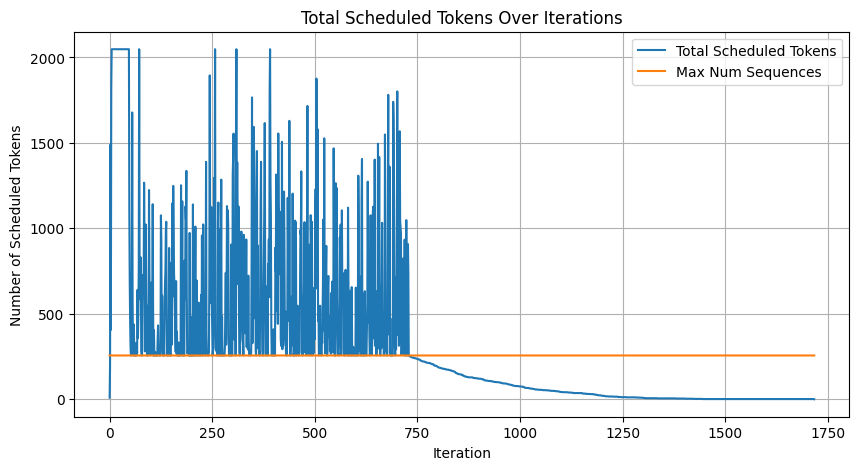

In [16]:
df = parse_csv("profiling/test/execution_stats_1426_1000_0.0_Qwen-Qwen2.5-0.5B_sharegpt.csv")
df['num_total_scheduled_tokens']

import matplotlib.pyplot as plt

# plot num_total_scheduled_tokens at each iteration
plt.figure(figsize=(10, 5))
plt.plot(df['num_total_scheduled_tokens'], label='Total Scheduled Tokens')
plt.plot(df['max_num_sequences'], label='Max Num Sequences')
plt.xlabel('Iteration')
plt.ylabel('Number of Scheduled Tokens')
plt.title('Total Scheduled Tokens Over Iterations')
plt.legend()
plt.grid()
plt.show()


0       9
1       0
2       9
3       1
4       1
       ..
1767    1
1768    1
1769    1
1770    1
1771    0
Name: num_total_scheduled_tokens, Length: 1772, dtype: int64